# 라벨 백테스팅
### 과연 라벨 수익률은 얼마인가? 수익률 기반으로 정확히 잘만들어졌는가?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class SimpleBacktester:
    def __init__(self, data_path, start_date='2004-01-01', end_date='2014-12-31'):
        """
        3단계 라벨용 개별 종목 백테스터
        
        Parameters:
        -----------
        data_path : str
            CSV 파일들이 저장된 경로
        start_date : str
            백테스팅 시작 날짜
        end_date : str
            백테스팅 종료 날짜
        """
        self.data_path = data_path
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.stocks_data = {}
        self.results = {}
        
    def load_data(self):
        """CSV 파일들 로딩 (유연하게)"""
        # 다양한 패턴 시도
        patterns = ["*_enhanced.csv", "*_cleaned.csv", "*.csv"]
        csv_files = []
        
        for pattern in patterns:
            files = glob.glob(os.path.join(self.data_path, pattern))
            if files:
                csv_files = files
                print(f"파일 패턴 발견: {pattern} ({len(files)}개)")
                break
        
        if not csv_files:
            raise FileNotFoundError(f"CSV 파일을 찾을 수 없습니다: {self.data_path}")
        
        print(f"CSV 파일 로딩 중... ({len(csv_files)}개)")
        
        for file_path in tqdm(csv_files):
            try:
                # 파일명에서 종목명 추출
                filename = os.path.basename(file_path)
                symbol = filename.replace('.csv', '')
                for suffix in ['_enhanced', '_cleaned', '_processed']:
                    symbol = symbol.replace(suffix, '')
                
                # CSV 읽기
                df = pd.read_csv(file_path)
                
                # 날짜 컬럼 처리
                if 'Date' in df.columns:
                    df['Date'] = pd.to_datetime(df['Date'])
                    df.set_index('Date', inplace=True)
                elif 'Unnamed: 0' in df.columns:
                    df['Date'] = pd.to_datetime(df['Unnamed: 0'])
                    df.set_index('Date', inplace=True)
                    df.drop('Unnamed: 0', axis=1, inplace=True)
                else:
                    df.index = pd.to_datetime(df.index)
                
                # 필수 컬럼 확인
                if not all(col in df.columns for col in ['Close', 'Label']):
                    continue
                    
                # Label_Name이 없으면 3단계 라벨맵으로 생성
                if 'Label_Name' not in df.columns:
                    label_map = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
                    df['Label_Name'] = df['Label'].map(label_map)
                
                # 날짜 범위 필터링
                df = df.loc[self.start_date:self.end_date]
                
                if len(df) > 100:
                    self.stocks_data[symbol] = df
                    
            except Exception as e:
                print(f"파일 로딩 실패: {filename} - {e}")
        
        print(f"로딩 완료: {len(self.stocks_data)}개 종목")
        return self.stocks_data
    
    def simulate_trading(self, symbol, initial_capital=10000, transaction_cost=0.001):
        """3단계 라벨 기반 매매 시뮬레이션"""
        
        df = self.stocks_data[symbol].copy()
        
        # 시뮬레이션 변수
        cash = initial_capital
        shares = 0
        portfolio_values = []
        trades = []
        position = 'CASH'  # CASH, LONG
        
        for date, row in df.iterrows():
            current_price = row['Close']
            label = row['Label']
            label_name = row['Label_Name']
            
            # 포트폴리오 가치 계산
            portfolio_value = cash + (shares * current_price)
            portfolio_values.append(portfolio_value)
            
            # 3단계 라벨에 따른 매매 신호 처리
            if label == 2 and position == 'CASH':  # Strong_Buy (라벨=2) 신호
                shares_to_buy = cash / (current_price * (1 + transaction_cost))
                if shares_to_buy > 0:
                    shares += shares_to_buy
                    cash -= shares_to_buy * current_price * (1 + transaction_cost)
                    position = 'LONG'
                    
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': current_price,
                        'shares': shares_to_buy,
                        'value': shares_to_buy * current_price,
                        'label': label_name
                    })
            
            elif label == 0 and position == 'LONG':  # Strong_Sell (라벨=0) 신호
                if shares > 0:
                    sale_value = shares * current_price * (1 - transaction_cost)
                    cash += sale_value
                    
                    trades.append({
                        'date': date,
                        'action': 'SELL',
                        'price': current_price,
                        'shares': shares,
                        'value': sale_value,
                        'label': label_name
                    })
                    
                    shares = 0
                    position = 'CASH'
            
            # Hold (라벨=1)일 때는 기존 포지션 유지
        
        # 최종 정산 (보유주식 강제 매도)
        if shares > 0:
            final_price = df.iloc[-1]['Close']
            final_value = shares * final_price * (1 - transaction_cost)
            cash += final_value
            
            trades.append({
                'date': df.index[-1],
                'action': 'FINAL_SELL',
                'price': final_price,
                'shares': shares,
                'value': final_value,
                'label': 'FINAL'
            })
        
        # 결과 계산
        df['Portfolio_Value'] = portfolio_values
        final_value = cash
        total_return = (final_value - initial_capital) / initial_capital
        
        # Buy & Hold: 첫날 매수해서 마지막날 매도
        buy_hold_return = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close']
        
        # 샤프 비율: (평균 일일수익률 / 수익률 변동성) × √252
        daily_returns = df['Portfolio_Value'].pct_change().dropna()
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
        
        # 최대 손실폭 (Maximum Drawdown)
        peak = df['Portfolio_Value'].expanding().max()
        drawdown = (df['Portfolio_Value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # 승률 계산 (매매당 수익률)
        trade_returns = []
        for i in range(0, len(trades)-1, 2):  # 매수-매도 쌍으로 계산
            if i+1 < len(trades):
                buy_trade = trades[i]
                sell_trade = trades[i+1]
                trade_return = (sell_trade['price'] - buy_trade['price']) / buy_trade['price']
                trade_returns.append(trade_return)
        
        win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns) if trade_returns else 0
        avg_trade_return = np.mean(trade_returns) if trade_returns else 0
        
        return {
            'symbol': symbol,
            'initial_capital': initial_capital,
            'final_value': final_value,
            'total_return': total_return,
            'buy_hold_return': buy_hold_return,
            'excess_return': total_return - buy_hold_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': len(trades),
            'win_rate': win_rate,
            'avg_trade_return': avg_trade_return,
            'trades': trades,
            'portfolio_values': df['Portfolio_Value'].values,
            'dates': df.index.values
        }
    
    def plot_individual_stock(self, symbol, figsize=(15, 10)):
        """개별 종목 백테스팅 결과 시각화 (3단계 라벨용)"""
        
        if symbol not in self.results:
            print(f"{symbol} 결과가 없습니다.")
            return
        
        result = self.results[symbol]
        df = self.stocks_data[symbol]
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        # 1. 가격 차트 + 매매 신호
        ax1 = axes[0]
        ax1.plot(df.index, df['Close'], label='Close Price', alpha=0.7, color='black')
        
        # 매매 포인트 표시
        trades = result['trades']
        buy_trades = [t for t in trades if t['action'] == 'BUY']
        sell_trades = [t for t in trades if t['action'] in ['SELL', 'FINAL_SELL']]
        
        if buy_trades:
            buy_dates = [t['date'] for t in buy_trades]
            buy_prices = [t['price'] for t in buy_trades]
            ax1.scatter(buy_dates, buy_prices, color='green', marker='^', 
                       s=100, label=f'Buy Signals ({len(buy_trades)})', zorder=5)
        
        if sell_trades:
            sell_dates = [t['date'] for t in sell_trades]
            sell_prices = [t['price'] for t in sell_trades]
            ax1.scatter(sell_dates, sell_prices, color='red', marker='v', 
                       s=100, label=f'Sell Signals ({len(sell_trades)})', zorder=5)
        
        ax1.set_title(f'{symbol} - Price & Trading Signals')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # X축 월 단위로 설정
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. 포트폴리오 가치 vs Buy & Hold 비교
        ax2 = axes[1]
        ax2.plot(df.index, result['portfolio_values'], label='Strategy Portfolio', color='blue', linewidth=2)
        
        # Buy & Hold 비교 (첫날 매수 → 마지막날 매도)
        buy_hold_values = (df['Close'] / df.iloc[0]['Close']) * result['initial_capital']
        ax2.plot(df.index, buy_hold_values, label='Buy & Hold', color='orange', alpha=0.7)
        
        ax2.set_title(f'Portfolio Value Comparison')
        ax2.set_ylabel('Portfolio Value ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # X축 월 단위로 설정
        ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. 라벨 분포 (3단계)
        ax3 = axes[2]
        label_counts = df['Label'].value_counts().sort_index()
        
        # 3단계 라벨명과 색상
        label_names = {0: 'Strong_Sell', 1: 'Hold', 2: 'Strong_Buy'}
        colors = {0: 'red', 1: 'gray', 2: 'green'}
        
        # 막대 그래프
        labels_present = label_counts.index
        bar_colors = [colors[i] for i in labels_present]
        bar_labels = [label_names[i] for i in labels_present]
        
        bars = ax3.bar(range(len(label_counts)), label_counts.values, color=bar_colors)
        ax3.set_title('Label Distribution (3-Class)')
        ax3.set_xlabel('Signal Types')
        ax3.set_ylabel('Count')
        ax3.set_xticks(range(len(label_counts)))
        ax3.set_xticklabels(bar_labels)
        
        # 막대 위에 숫자 표시
        for i, count in enumerate(label_counts.values):
            ax3.text(i, count + 0.01*max(label_counts), str(count), 
                    ha='center', va='bottom')
        
        plt.tight_layout()
        
        # 결과 요약 출력
        print(f"\n{symbol} 백테스팅 결과:")
        print(f"전략 수익률: {result['total_return']:.2%}")
        print(f"Buy & Hold 수익률: {result['buy_hold_return']:.2%}")
        print(f"초과 수익률: {result['excess_return']:.2%}")
        print(f"샤프 비율: {result['sharpe_ratio']:.2f}")
        print(f"최대 손실폭: {result['max_drawdown']:.2%}")
        print(f"총 거래 횟수: {result['num_trades']}회")
        print(f"승률: {result['win_rate']:.2%}")
        print(f"평균 거래수익률: {result['avg_trade_return']:.2%}")
        print(f"최종 자산: ${result['final_value']:,.0f}")
        
        plt.show()
    
    def get_summary_stats(self):
        """전체 백테스팅 결과 요약"""
        if not self.results:
            print("백테스팅 결과가 없습니다.")
            return
        
        summary_data = []
        for symbol, result in self.results.items():
            summary_data.append({
                'Symbol': symbol,
                'Total_Return': result['total_return'],
                'Buy_Hold_Return': result['buy_hold_return'],
                'Excess_Return': result['excess_return'],
                'Sharpe_Ratio': result['sharpe_ratio'],
                'Max_Drawdown': result['max_drawdown'],
                'Win_Rate': result['win_rate'],
                'Num_Trades': result['num_trades']
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\n전체 백테스팅 결과 요약:")
        print("="*80)
        print(summary_df.to_string(index=False, float_format='%.3f'))
        
        # 평균 통계
        print(f"\n평균 통계:")
        print(f"평균 수익률: {summary_df['Total_Return'].mean():.2%}")
        print(f"평균 초과수익률: {summary_df['Excess_Return'].mean():.2%}")
        print(f"평균 샤프비율: {summary_df['Sharpe_Ratio'].mean():.2f}")
        print(f"평균 승률: {summary_df['Win_Rate'].mean():.2%}")
        
        return summary_df

def run_individual_backtest(data_path, start_date='2004-01-01', end_date='2014-12-31', 
                           symbols=None, max_stocks=5, initial_capital=10000):
    """
    3단계 라벨 기반 개별 종목 백테스팅 실행
    
    Parameters:
    -----------
    data_path : str
        CSV 파일 경로
    start_date : str
        백테스팅 시작 날짜
    end_date : str
        백테스팅 종료 날짜
    symbols : list, optional
        특정 종목만 테스트 (None이면 전체 또는 처음 몇 개)
    max_stocks : int
        최대 테스트 종목 수
    initial_capital : float
        초기 투자 금액
    """
    
    # 백테스터 생성 (기간 설정 포함)
    backtester = SimpleBacktester(data_path, start_date, end_date)
    
    # 데이터 로딩
    backtester.load_data()
    
    # 테스트할 종목 선택
    if symbols:
        stocks_to_test = [s for s in symbols if s in backtester.stocks_data]
    else:
        stocks_to_test = list(backtester.stocks_data.keys())[:max_stocks]
    
    print(f"\nBacktesting Period: {start_date} to {end_date}")
    print(f"Initial Capital: ${initial_capital:,}")
    print(f"3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)")
    print(f"Running backtest for {len(stocks_to_test)} stocks...")
    
    # 각 종목별 백테스팅 및 시각화
    for symbol in stocks_to_test:
        result = backtester.simulate_trading(symbol, initial_capital)
        if result:
            backtester.results[symbol] = result
            backtester.plot_individual_stock(symbol)
    
    # 전체 결과 요약
    summary_df = backtester.get_summary_stats()
    
    return backtester, summary_df

# 종목별 기간 백테스팅

파일 패턴 발견: *_enhanced.csv (100개)
CSV 파일 로딩 중... (100개)


100%|██████████| 100/100 [00:11<00:00,  8.78it/s]


로딩 완료: 100개 종목

Backtesting Period: 2015-01-01 to 2025-12-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

1INCH 백테스팅 결과:
전략 수익률: 17086398936.82%
Buy & Hold 수익률: -88.66%
초과 수익률: 17086399025.48%
샤프 비율: 4.52
최대 손실폭: -25.81%
총 거래 횟수: 274회
승률: 97.81%
평균 거래수익률: 17.90%
최종 자산: $1,708,639,903,682


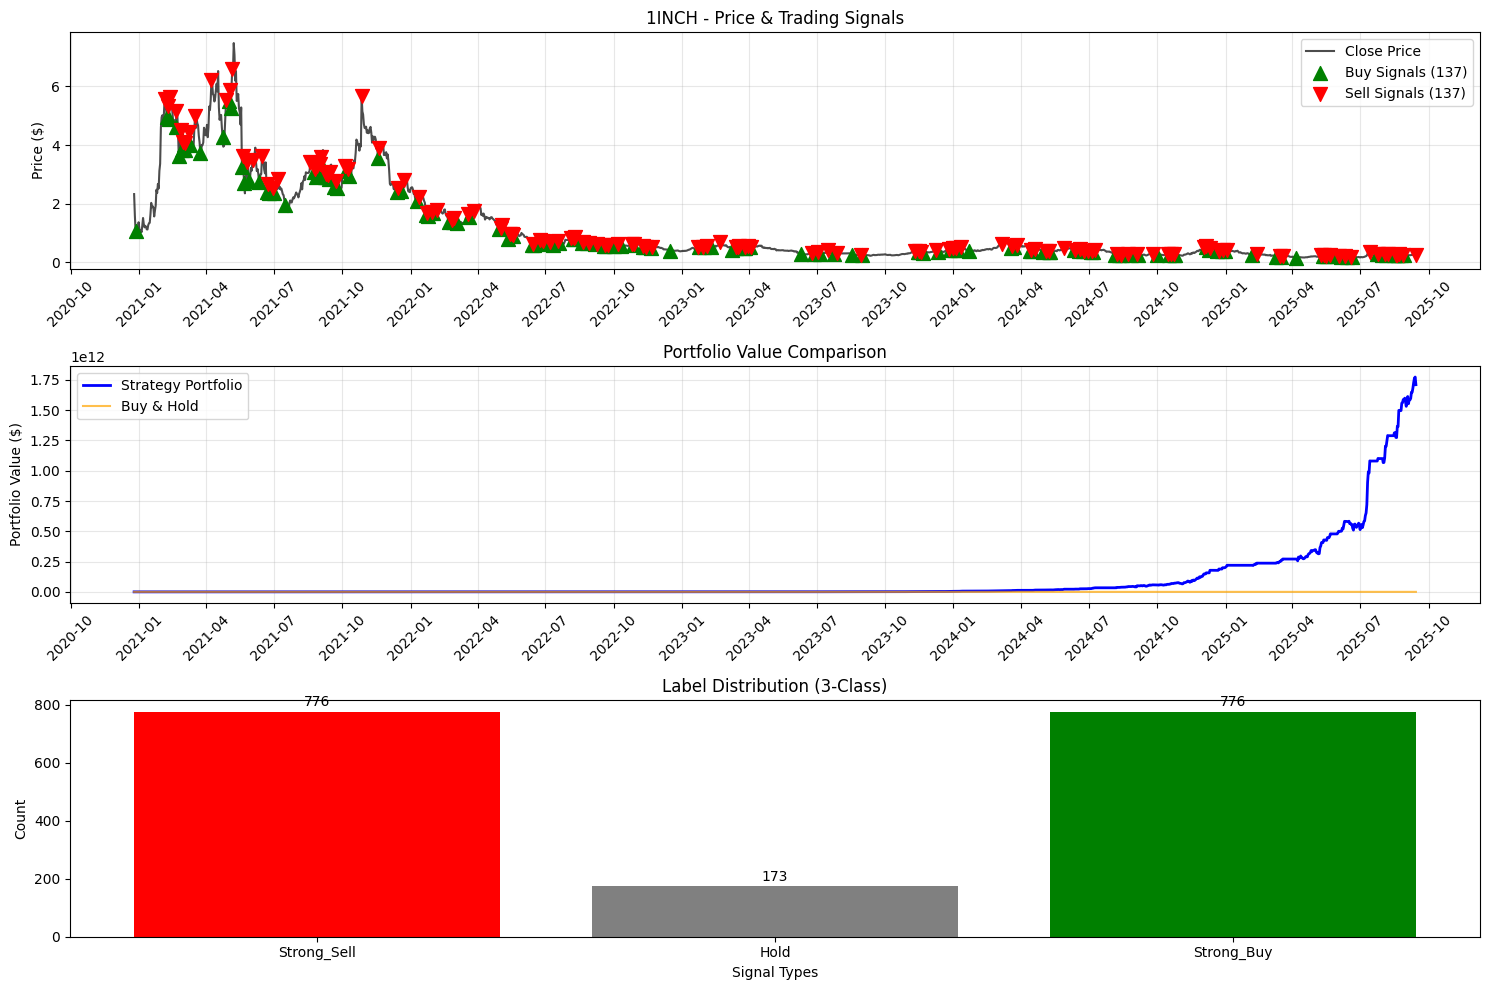


AAVE 백테스팅 결과:
전략 수익률: 13070894988091.22%
Buy & Hold 수익률: 59244.53%
초과 수익률: 13070894928846.69%
샤프 비율: 0.46
최대 손실폭: -38.27%
총 거래 횟수: 262회
승률: 100.00%
평균 거래수익률: 102.30%
최종 자산: $1,307,089,498,819,122


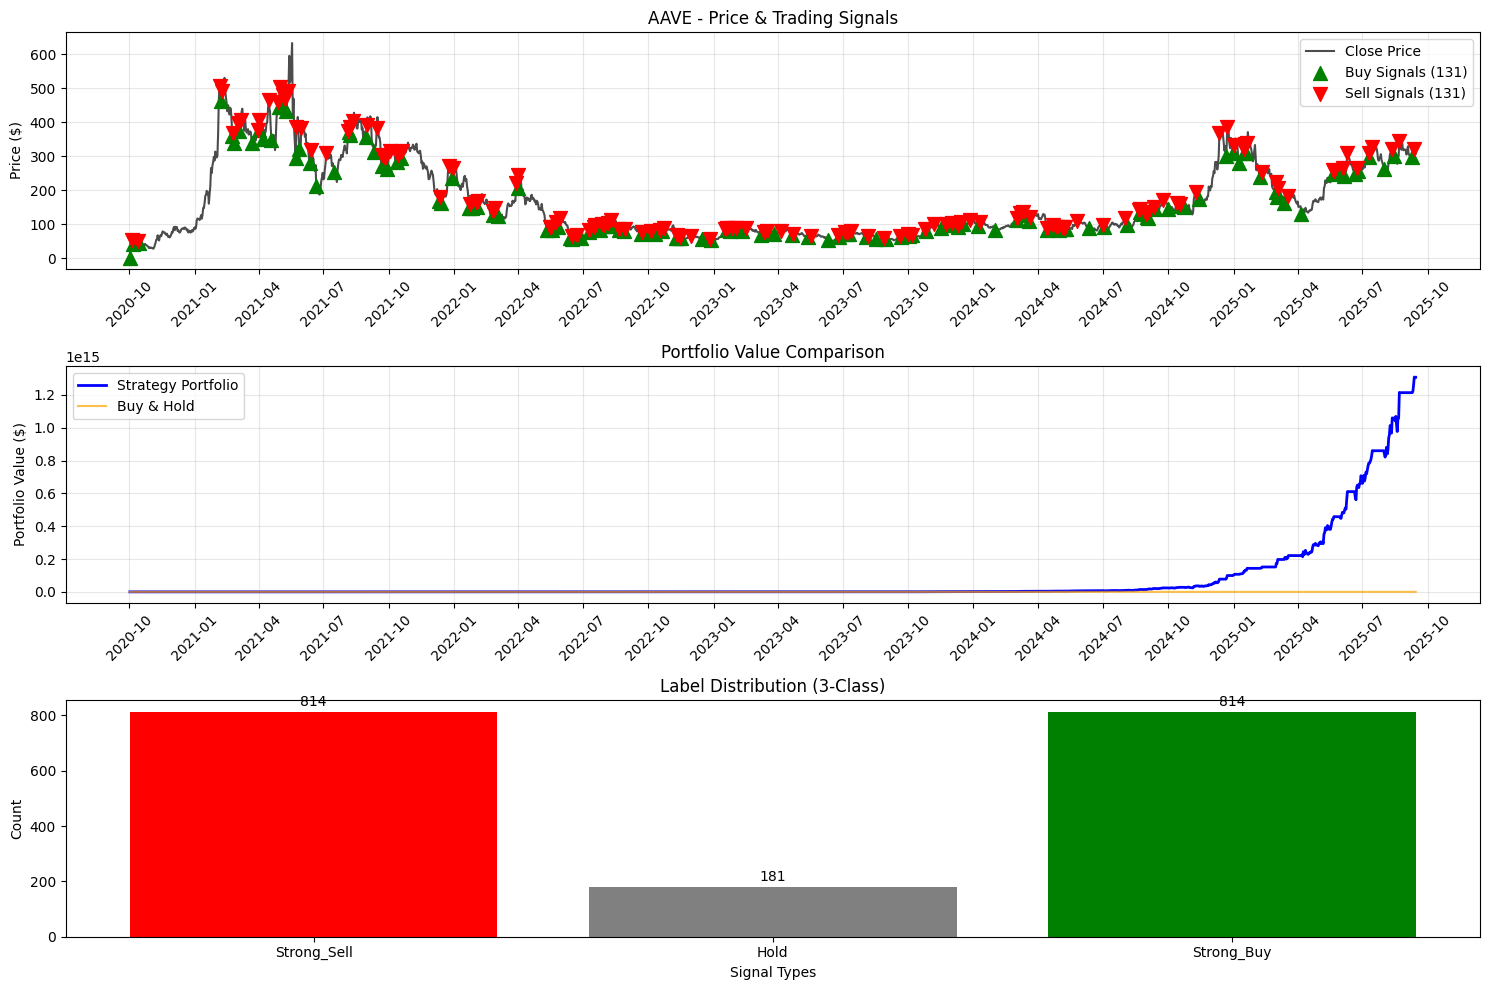


ADA 백테스팅 결과:
전략 수익률: 3772834374530205.50%
Buy & Hold 수익률: 2673.50%
초과 수익률: 3772834374527532.00%
샤프 비율: 3.48
최대 손실폭: -38.79%
총 거래 횟수: 342회
승률: 98.83%
평균 거래수익률: 34.04%
최종 자산: $377,283,437,453,030,528


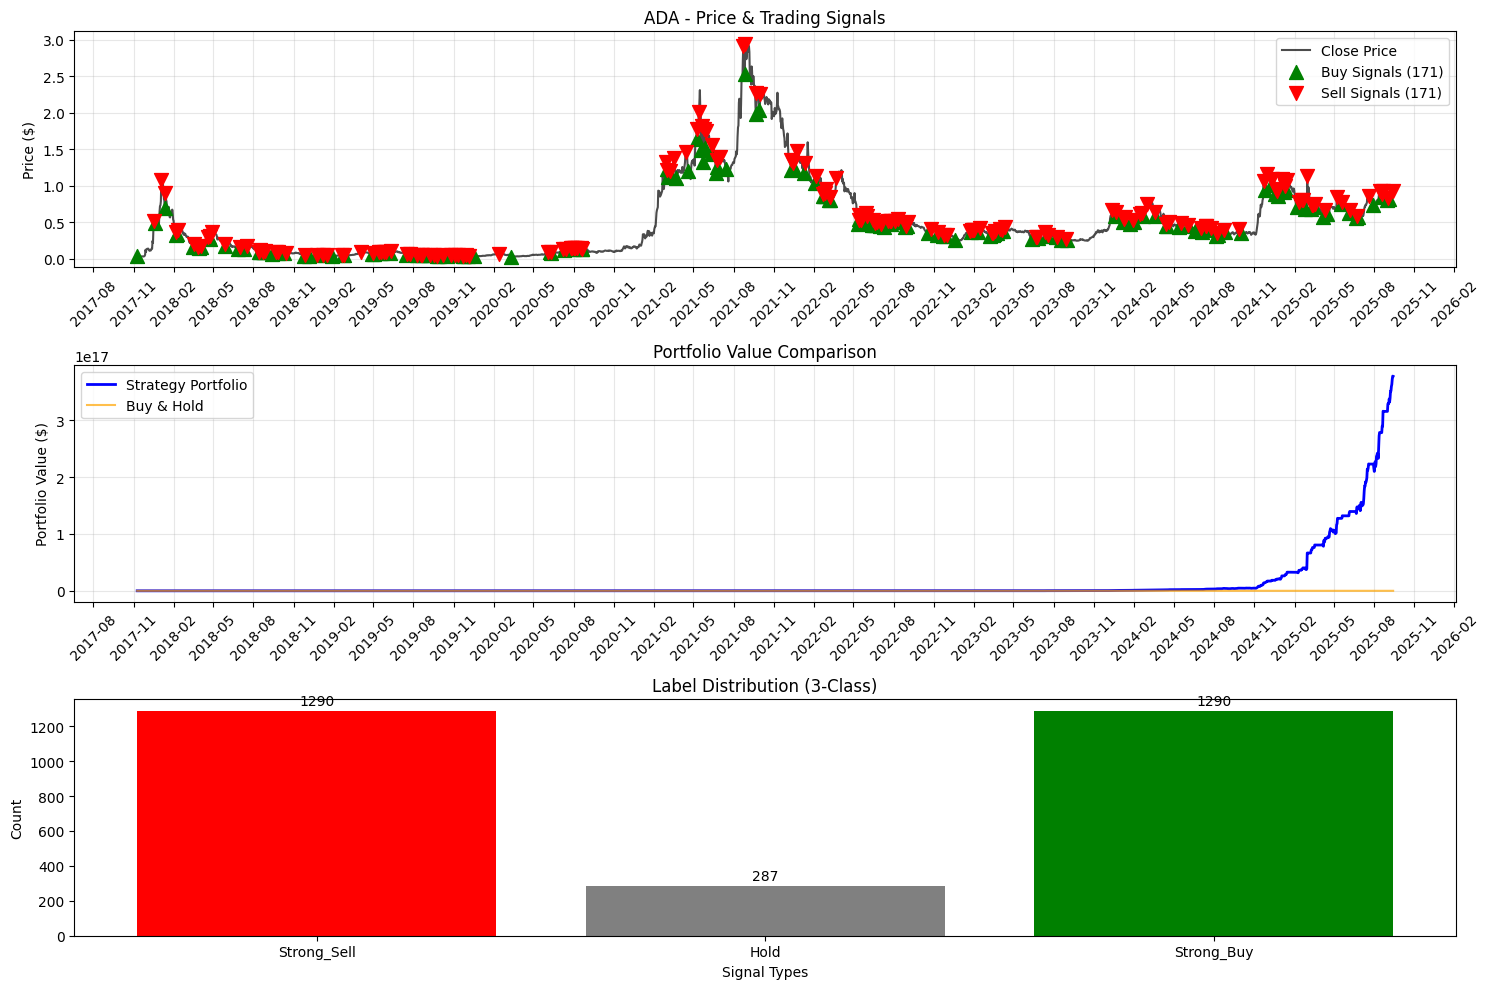


ALGO 백테스팅 결과:
전략 수익률: 3685614467888.80%
Buy & Hold 수익률: -92.52%
초과 수익률: 3685614467981.32%
샤프 비율: 4.33
최대 손실폭: -26.50%
총 거래 횟수: 308회
승률: 100.00%
평균 거래수익률: 21.10%
최종 자산: $368,561,446,798,880


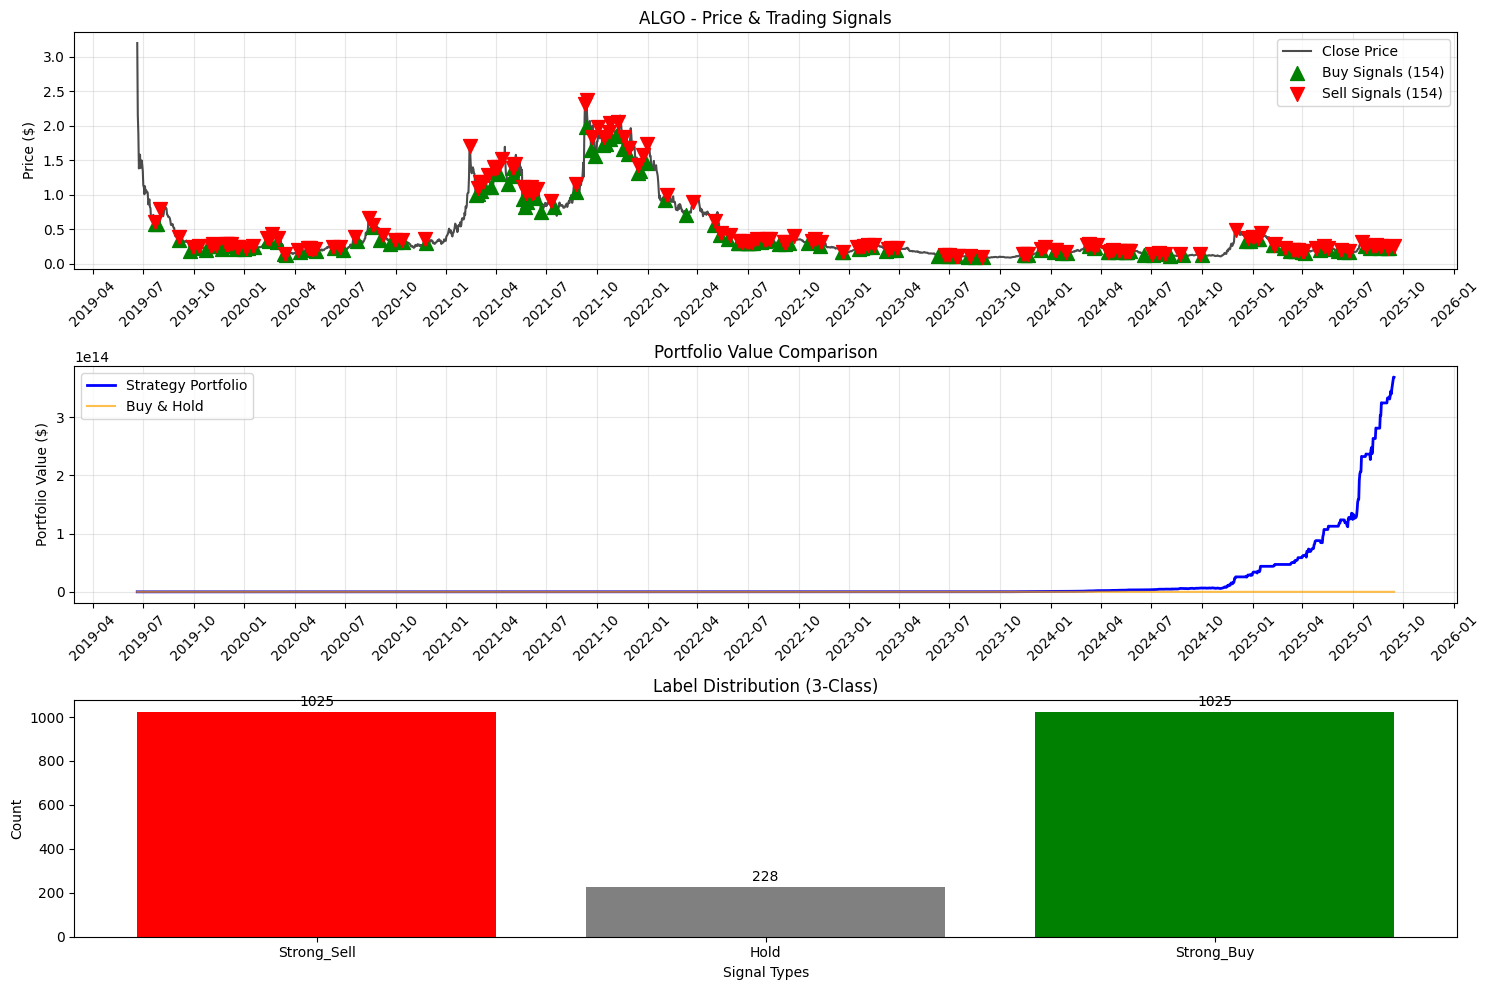


ANKR 백테스팅 결과:
전략 수익률: 17226922990529.38%
Buy & Hold 수익률: 14.63%
초과 수익률: 17226922990514.75%
샤프 비율: 3.87
최대 손실폭: -39.68%
총 거래 횟수: 280회
승률: 100.00%
평균 거래수익률: 38.81%
최종 자산: $1,722,692,299,062,938


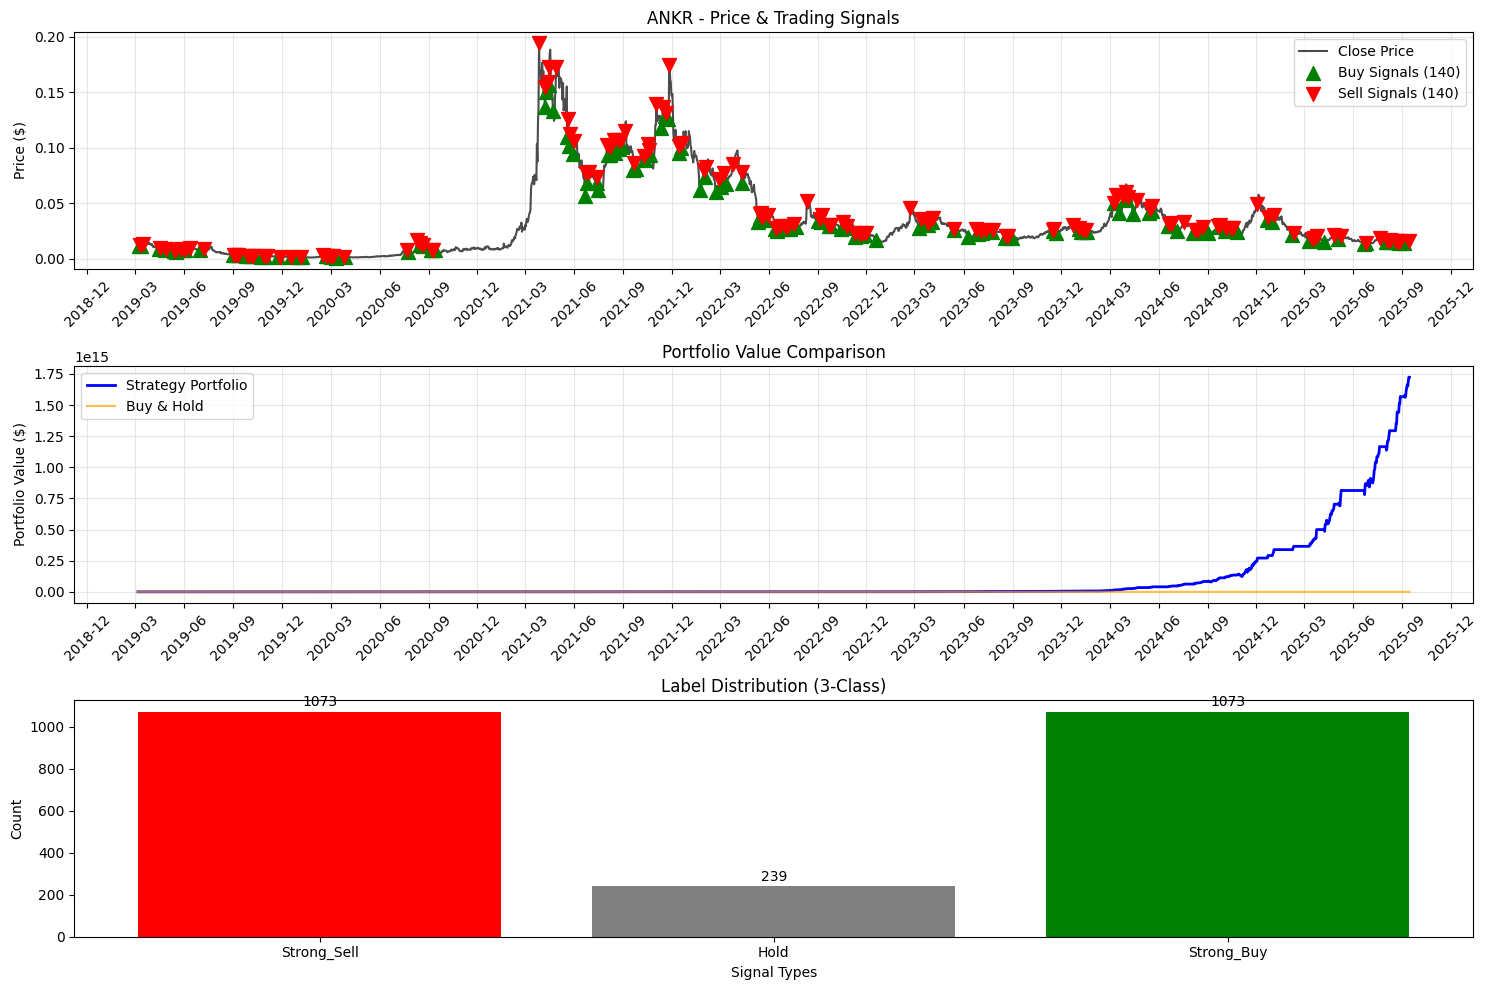


API3 백테스팅 결과:
전략 수익률: 18945904145333.81%
Buy & Hold 수익률: -27.49%
초과 수익률: 18945904145361.30%
샤프 비율: 4.24
최대 손실폭: -25.61%
총 거래 횟수: 300회
승률: 100.00%
평균 거래수익률: 20.67%
최종 자산: $1,894,590,414,543,381


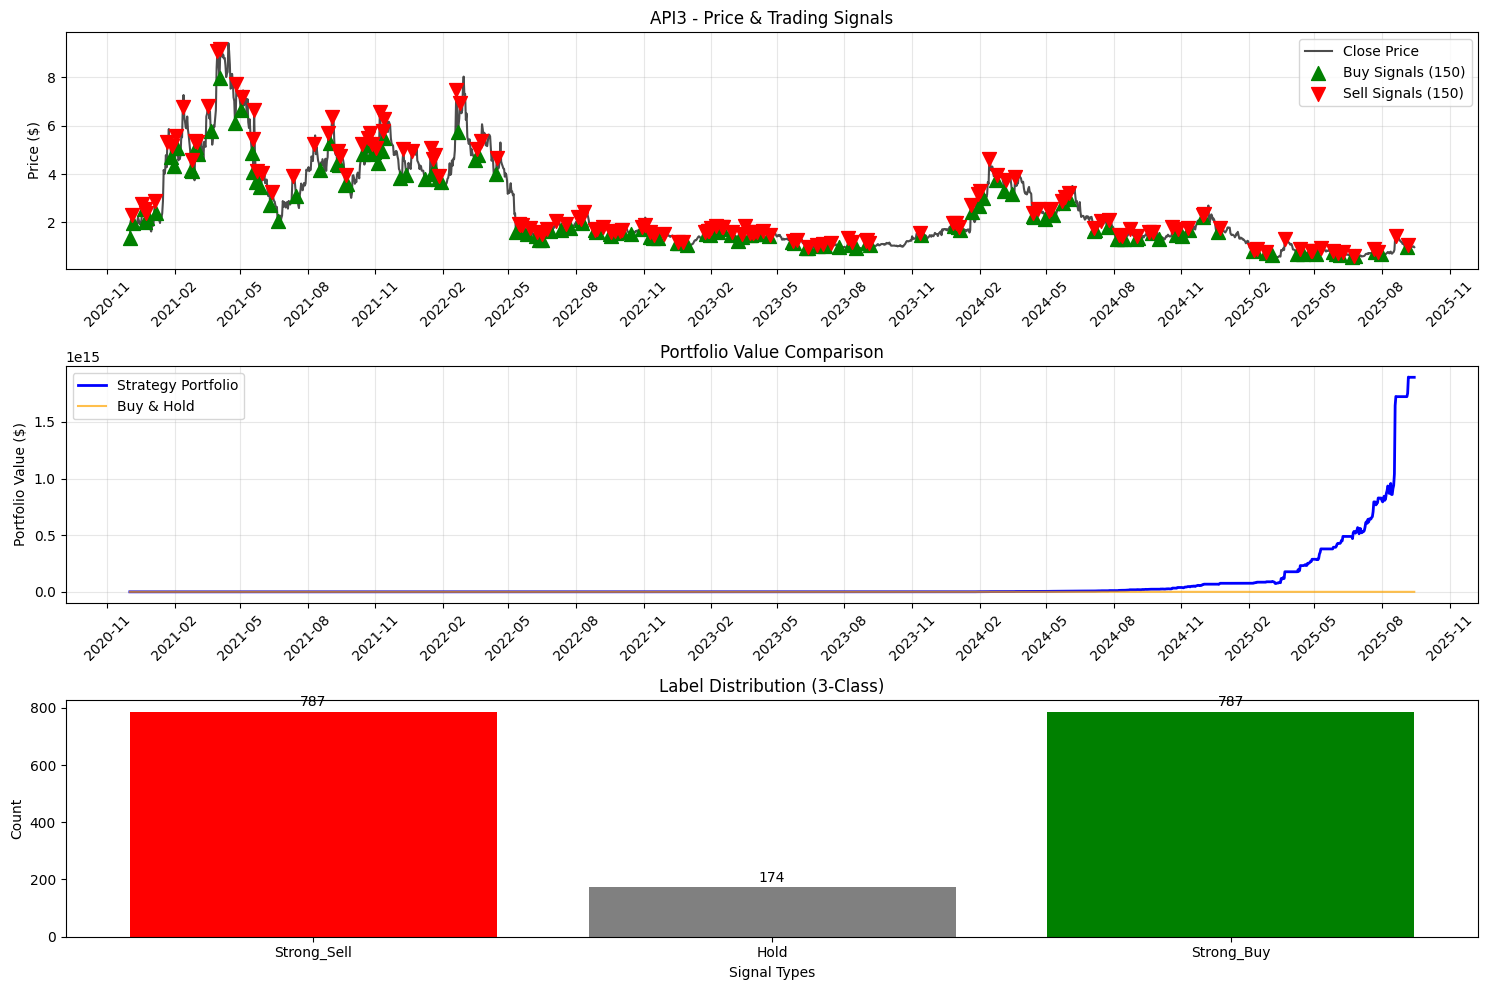


APT21794 백테스팅 결과:
전략 수익률: 5529192.29%
Buy & Hold 수익률: -37.45%
초과 수익률: 5529229.74%
샤프 비율: 4.31
최대 손실폭: -21.56%
총 거래 횟수: 190회
승률: 100.00%
평균 거래수익률: 14.76%
최종 자산: $552,929,229


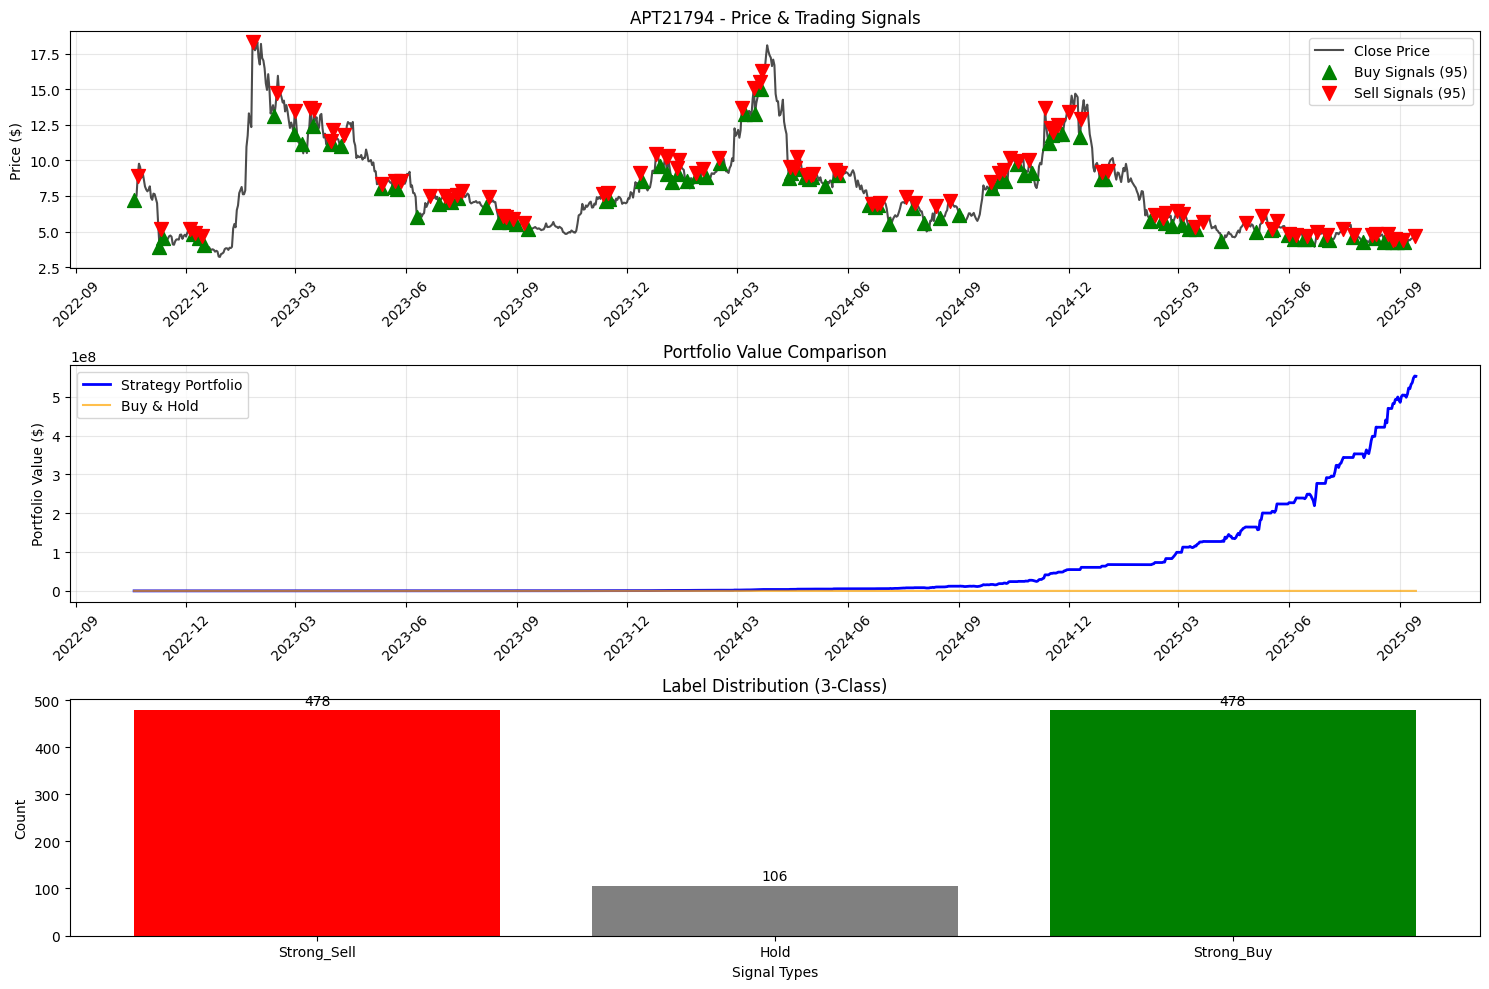


ARB11841 백테스팅 결과:
전략 수익률: 508728.42%
Buy & Hold 수익률: -61.38%
초과 수익률: 508789.80%
샤프 비율: 4.42
최대 손실폭: -16.14%
총 거래 횟수: 128회
승률: 98.44%
평균 거래수익률: 15.73%
최종 자산: $50,882,842


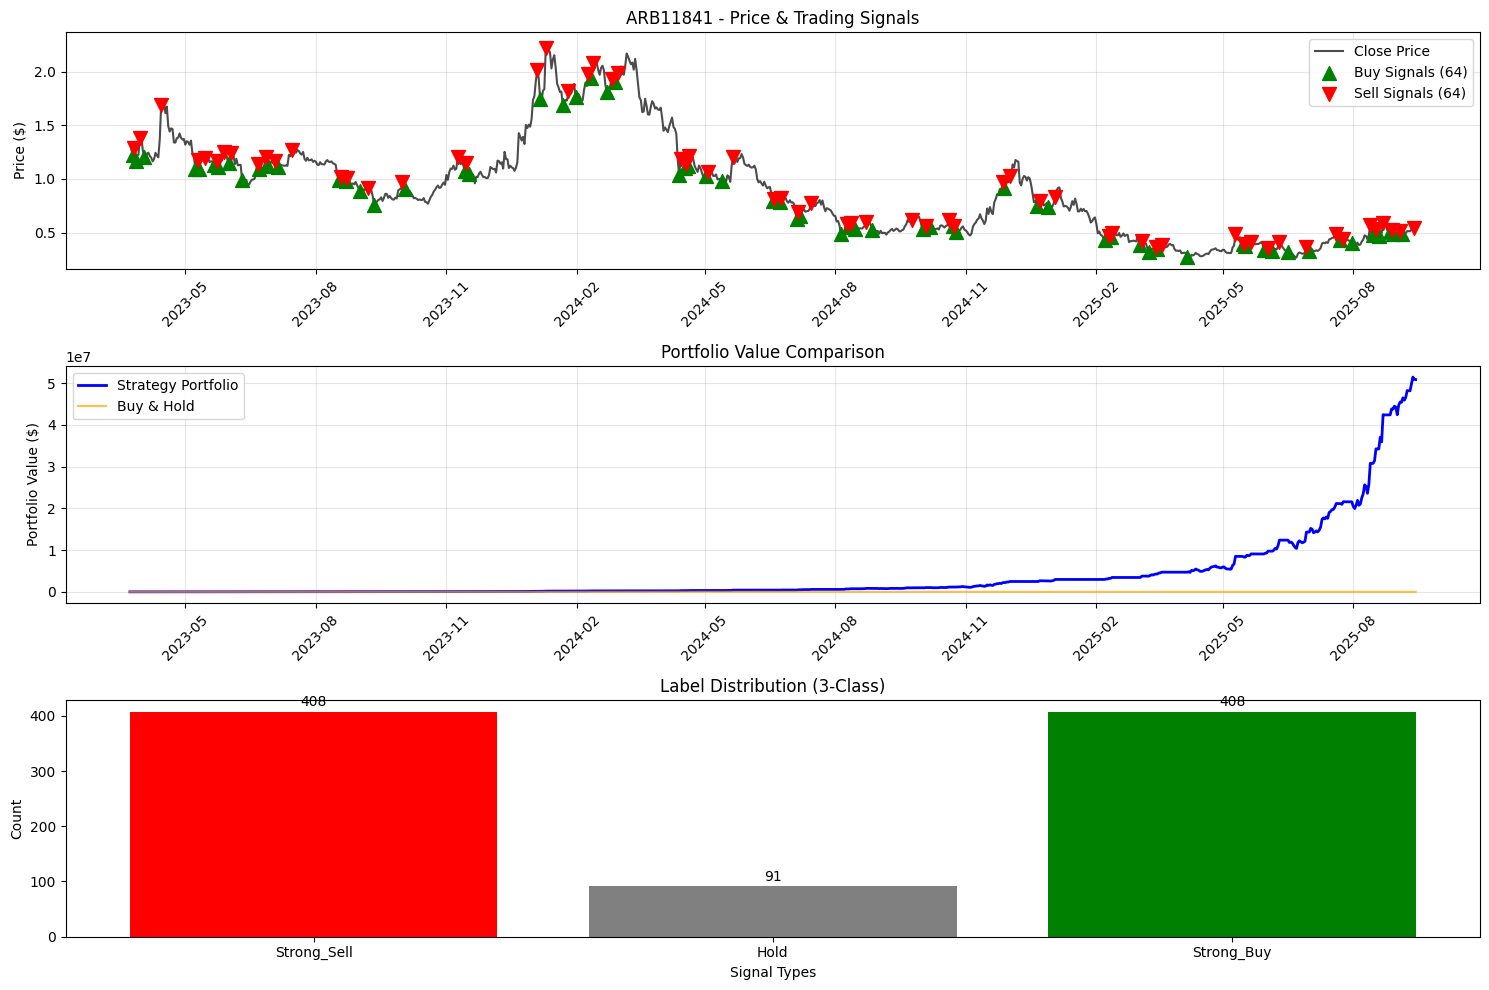


ASTR 백테스팅 결과:
전략 수익률: 21593077.35%
Buy & Hold 수익률: -86.46%
초과 수익률: 21593163.81%
샤프 비율: 4.35
최대 손실폭: -24.19%
총 거래 횟수: 176회
승률: 100.00%
평균 거래수익률: 17.30%
최종 자산: $2,159,317,735


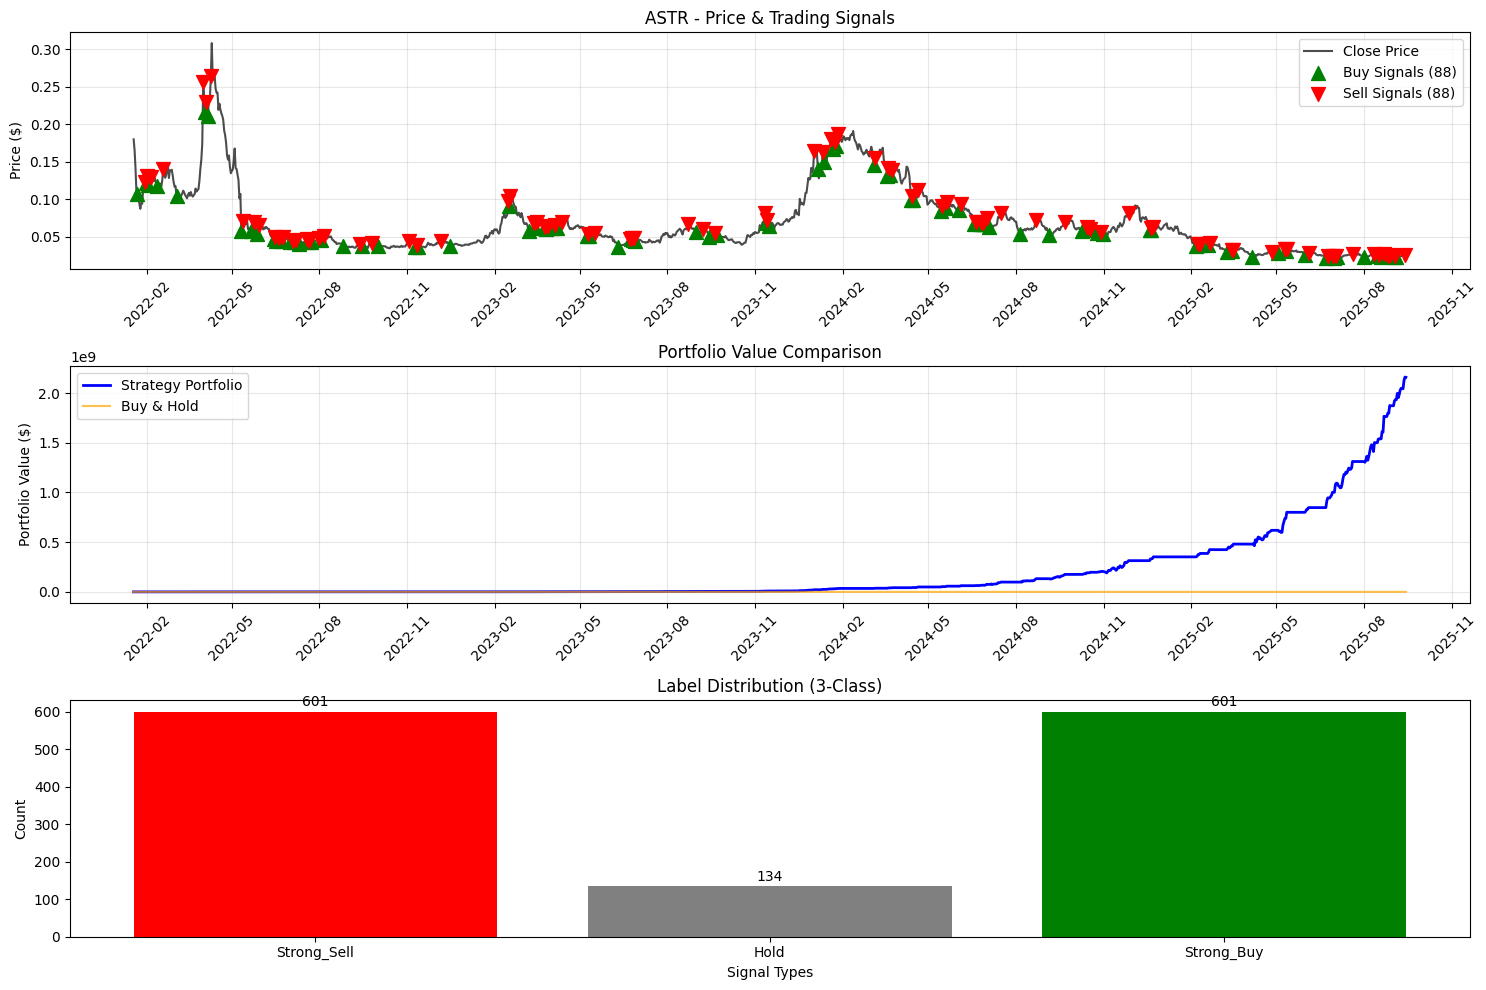


ATOM 백테스팅 결과:
전략 수익률: 26182298621096.45%
Buy & Hold 수익률: -28.87%
초과 수익률: 26182298621125.31%
샤프 비율: 4.45
최대 손실폭: -26.43%
총 거래 횟수: 366회
승률: 98.36%
평균 거래수익률: 17.84%
최종 자산: $2,618,229,862,119,644


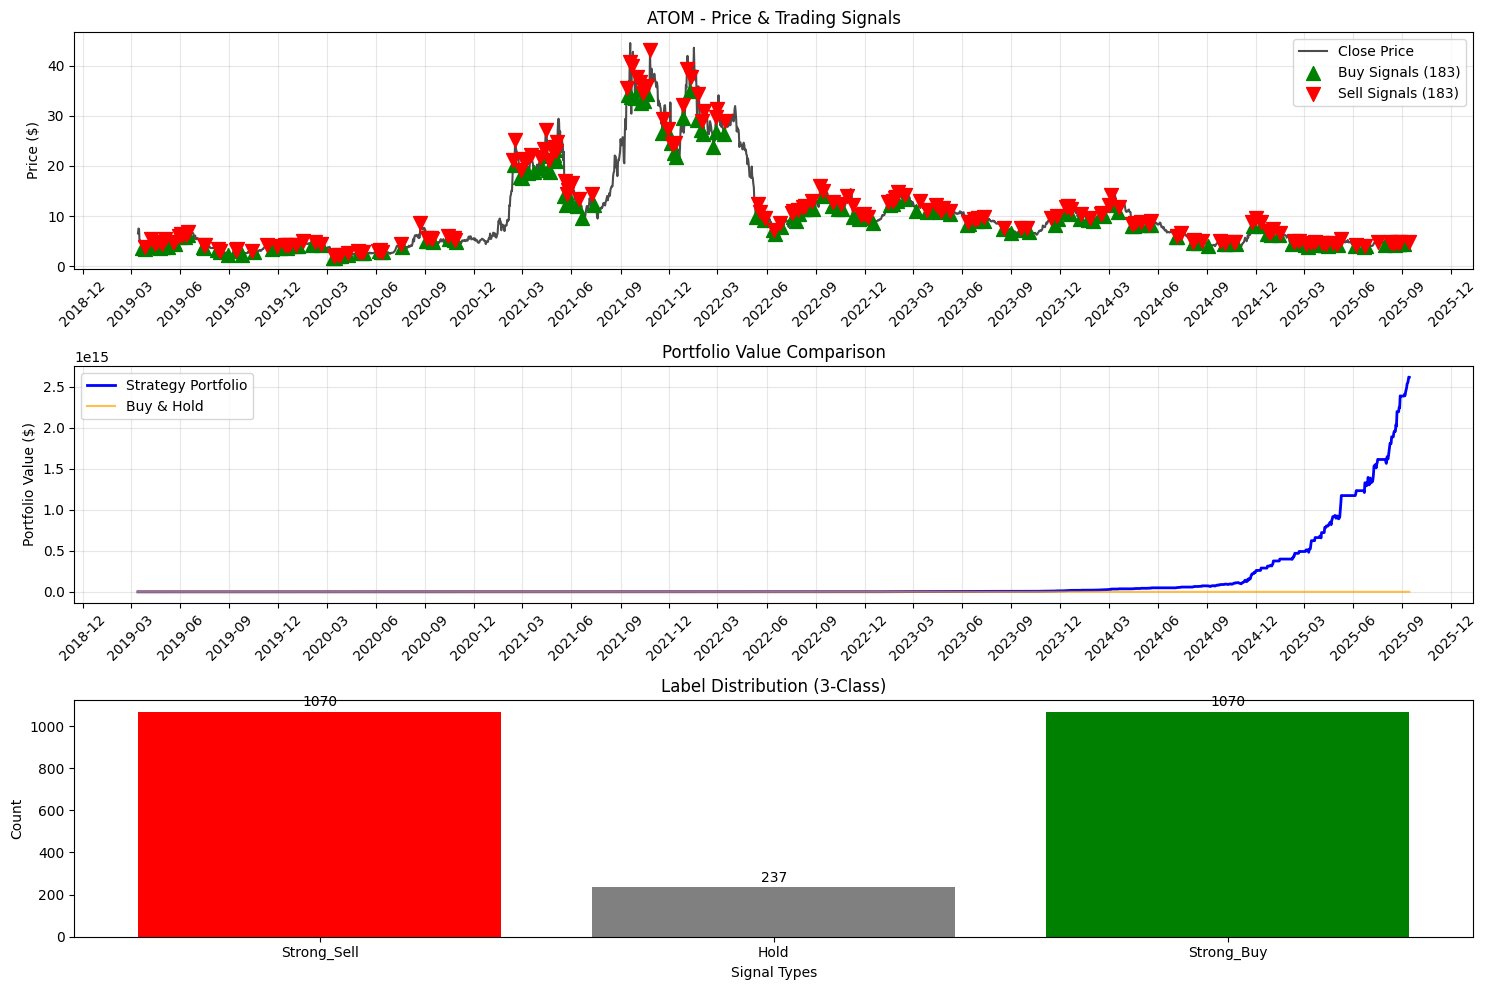


전체 백테스팅 결과 요약:
  Symbol       Total_Return  Buy_Hold_Return      Excess_Return  Sharpe_Ratio  Max_Drawdown  Win_Rate  Num_Trades
   1INCH      170863989.368           -0.887      170863990.255         4.519        -0.258     0.978         274
    AAVE   130708949880.912          592.445   130708949288.467         0.457        -0.383     1.000         262
     ADA 37728343745302.055           26.735 37728343745275.320         3.482        -0.388     0.988         342
    ALGO    36856144678.888           -0.925    36856144679.813         4.334        -0.265     1.000         308
    ANKR   172269229905.294            0.146   172269229905.147         3.871        -0.397     1.000         280
    API3   189459041453.338           -0.275   189459041453.613         4.238        -0.256     1.000         300
APT21794          55291.923           -0.374          55292.297         4.310        -0.216     1.000         190
ARB11841           5087.284           -0.614           5087.898         

In [6]:
# 모든 종목
save_path_1 = "/workspace/AI모델/projects/coin/data/labeling/00"
# 메이저 종목들만 
# save_path_1 = "/workspace/AI모델/projects/coin/data/labeling/m_00" 

# 실행 코드
if __name__ == "__main__":
    # 개별 종목 백테스팅 실행 (기간 설정 포함)
    backtester = run_individual_backtest(
        data_path=save_path_1,
        start_date='2015-01-01',    # 백테스팅 시작 날짜
        end_date='2025-12-31',      # 백테스팅 종료 날짜
        max_stocks=10,               # 처음 3개 종목만 테스트
        initial_capital=10000       # 초기 투자 금액
    )
    
    # 특정 종목만 테스트하려면:
    # backtester = run_individual_backtest(
    #     data_path=data_path,
    #     start_date='2005-01-01',
    #     end_date='2010-12-31',
    #     symbols=['AAPL', 'MSFT'],  # 원하는 종목 코드
    #     initial_capital=50000
    # )

# 연도별 백테스팅 실행

연도별 백테스팅 시작

2022년 백테스팅 실행 중...
파일 패턴 발견: *_enhanced.csv (100개)
CSV 파일 로딩 중... (100개)


100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


로딩 완료: 95개 종목

Backtesting Period: 2022-01-01 to 2022-12-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

1INCH 백테스팅 결과:
전략 수익률: 1355.00%
Buy & Hold 수익률: -84.82%
초과 수익률: 1439.82%
샤프 비율: 4.55
최대 손실폭: -8.66%
총 거래 횟수: 66회
승률: 96.97%
평균 거래수익률: 8.88%
최종 자산: $145,500


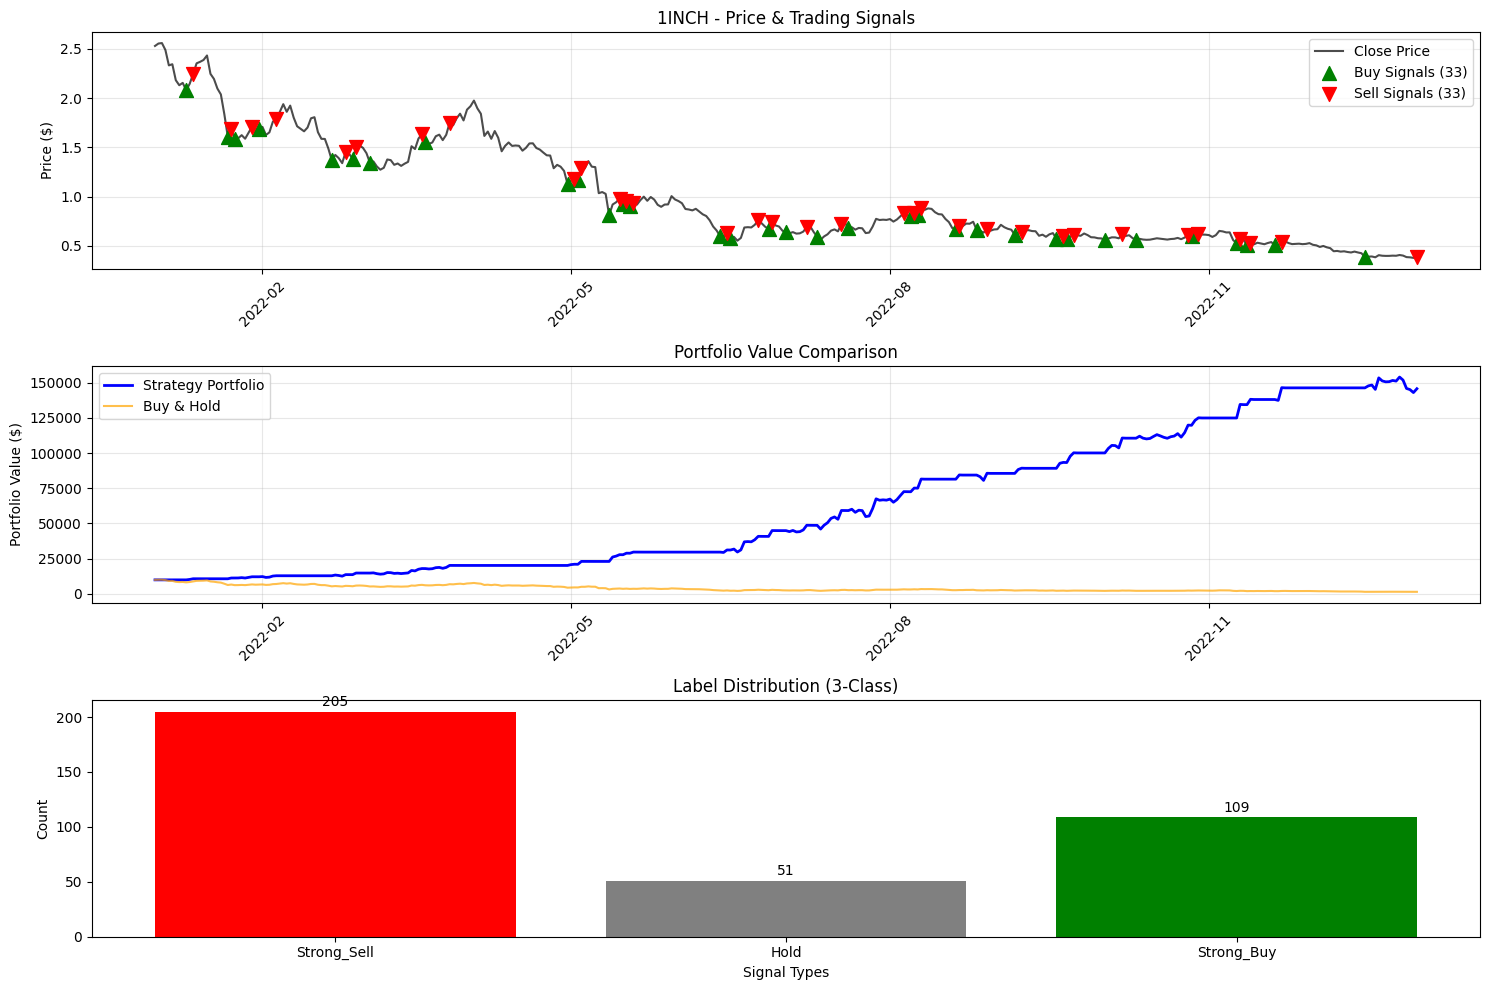


AAVE 백테스팅 결과:
전략 수익률: 5756.97%
Buy & Hold 수익률: -80.42%
초과 수익률: 5837.39%
샤프 비율: 4.63
최대 손실폭: -13.99%
총 거래 횟수: 62회
승률: 96.77%
평균 거래수익률: 14.98%
최종 자산: $585,697


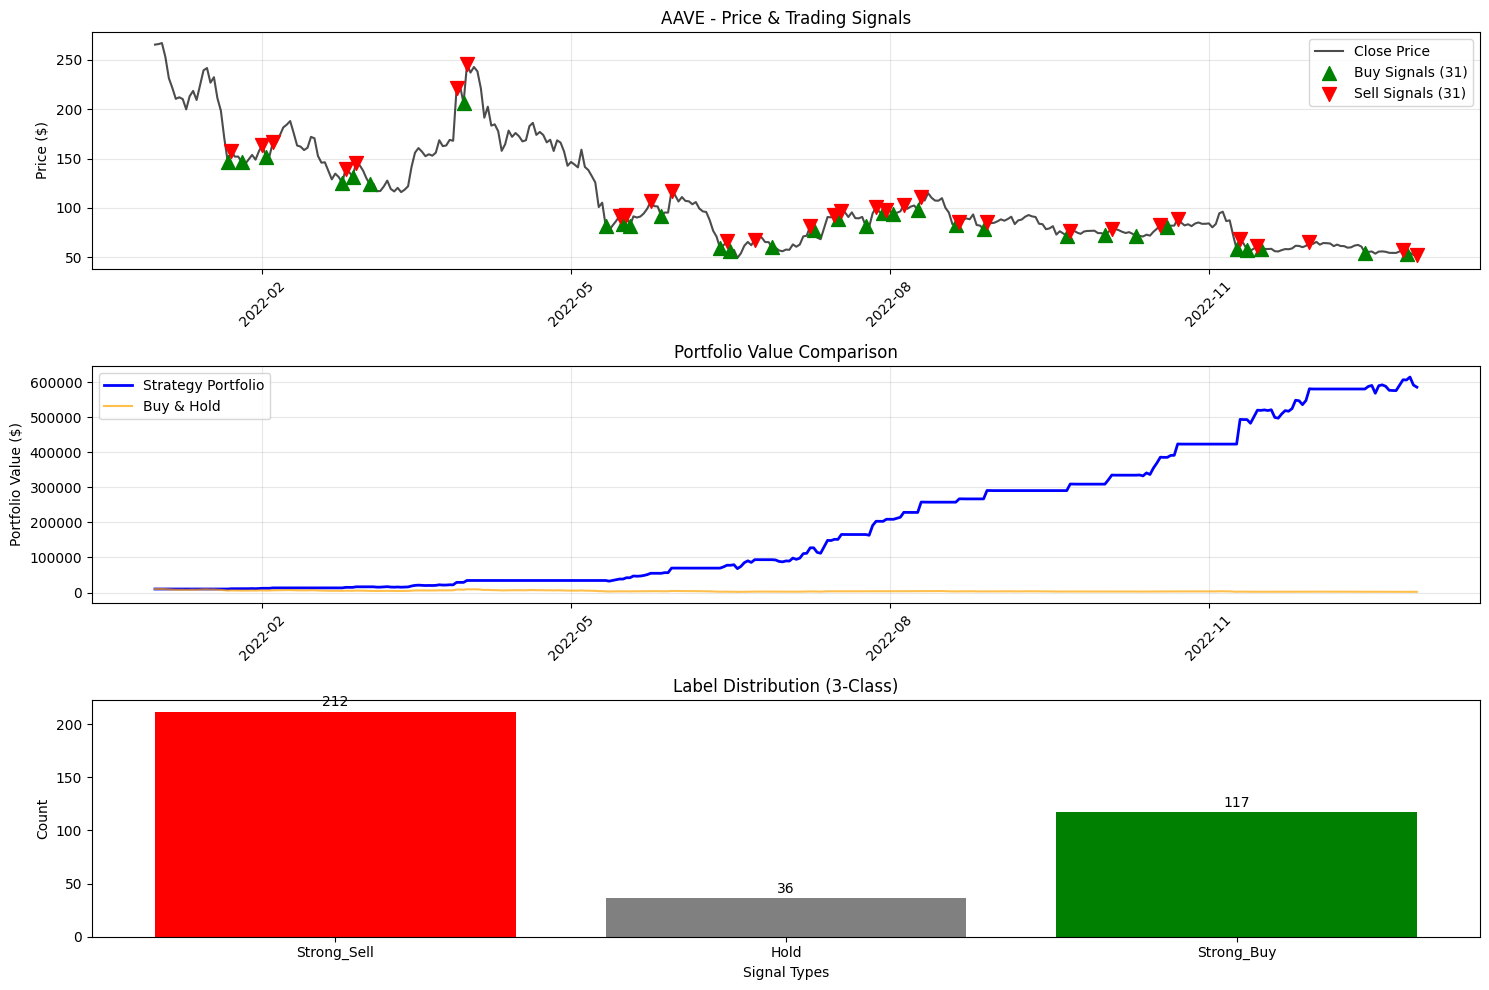


ADA 백테스팅 결과:
전략 수익률: 1164.29%
Buy & Hold 수익률: -82.10%
초과 수익률: 1246.39%
샤프 비율: 4.42
최대 손실폭: -7.97%
총 거래 횟수: 56회
승률: 96.43%
평균 거래수익률: 9.98%
최종 자산: $126,429


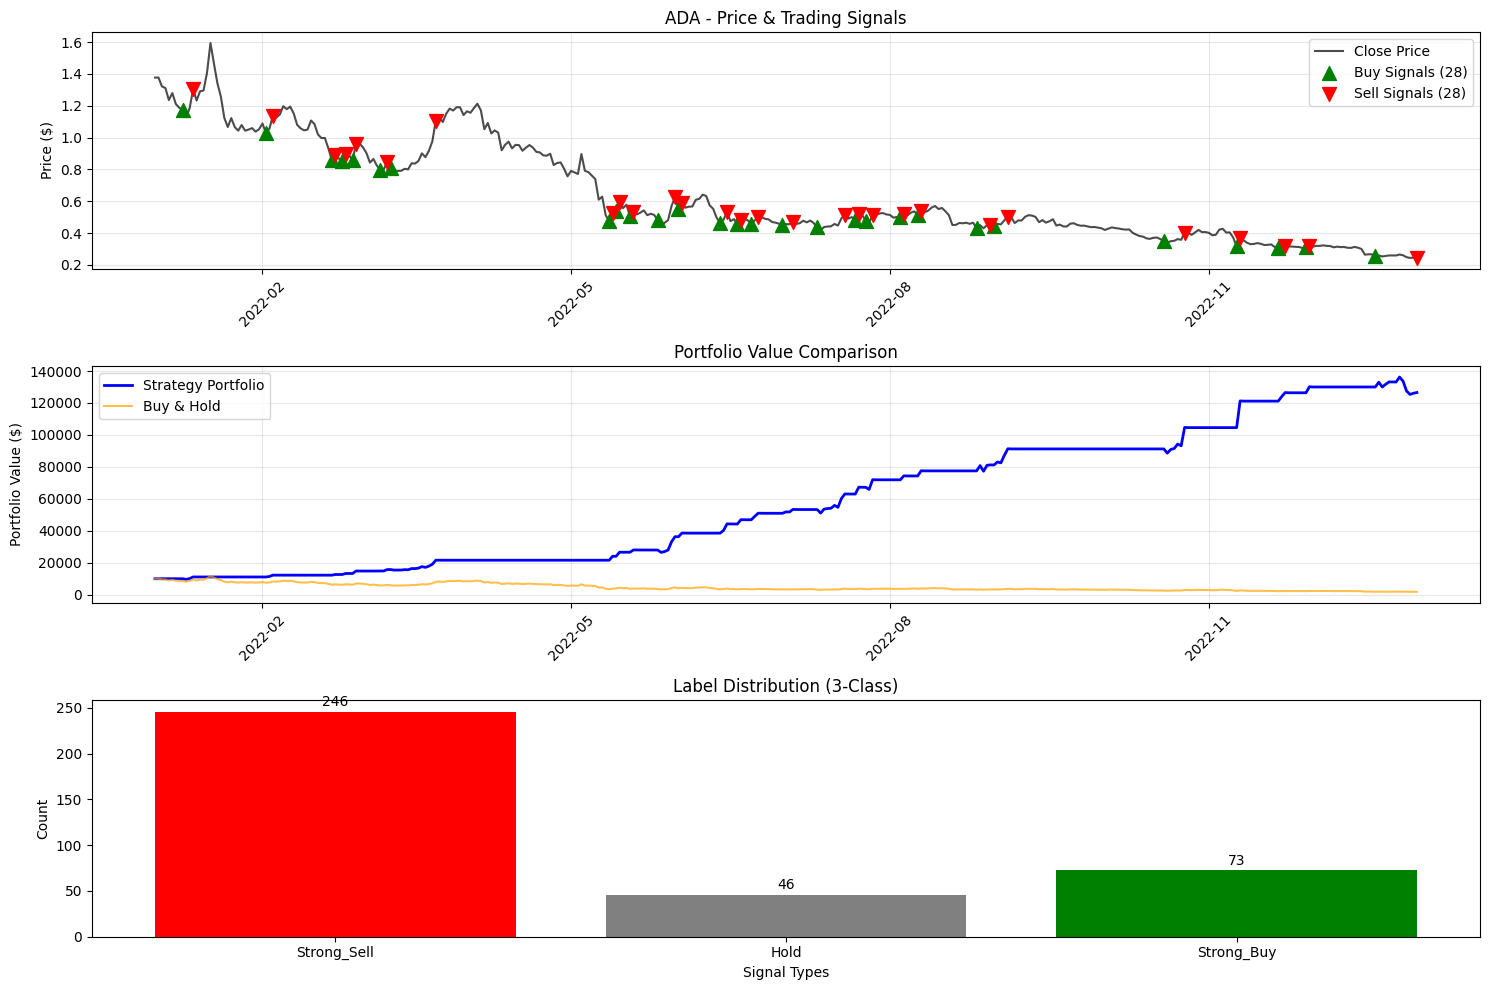


ALGO 백테스팅 결과:
전략 수익률: 923.99%
Buy & Hold 수익률: -90.07%
초과 수익률: 1014.06%
샤프 비율: 4.67
최대 손실폭: -5.92%
총 거래 횟수: 46회
승률: 100.00%
평균 거래수익률: 11.13%
최종 자산: $102,399


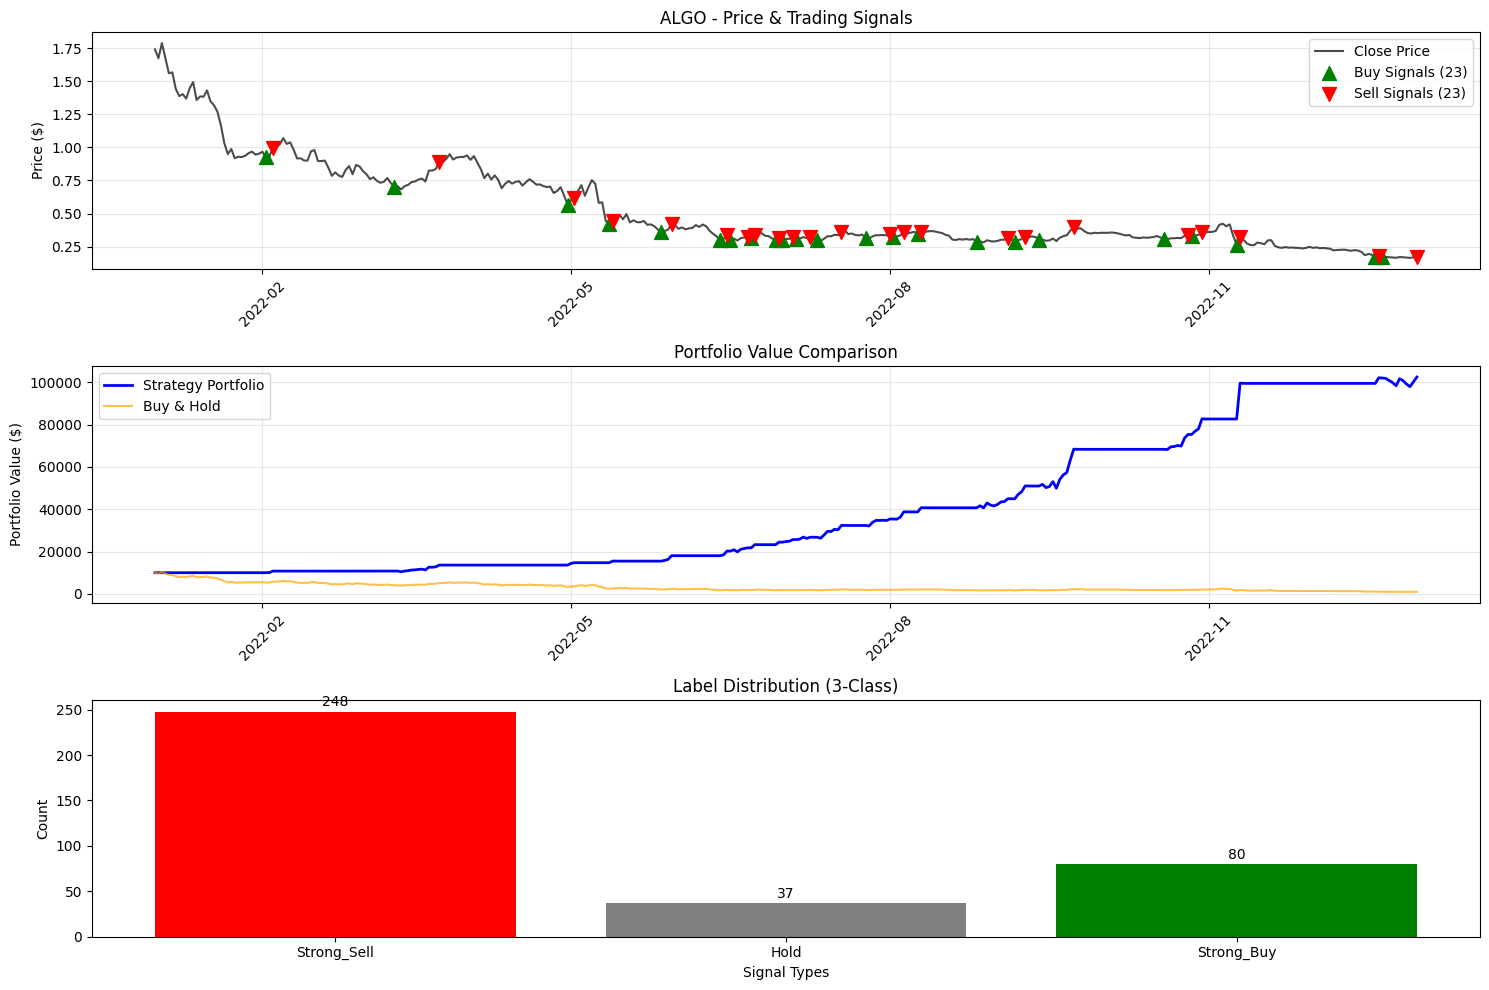


ANKR 백테스팅 결과:
전략 수익률: 3124.21%
Buy & Hold 수익률: -85.15%
초과 수익률: 3209.36%
샤프 비율: 4.27
최대 손실폭: -16.02%
총 거래 횟수: 56회
승률: 96.43%
평균 거래수익률: 14.26%
최종 자산: $322,421


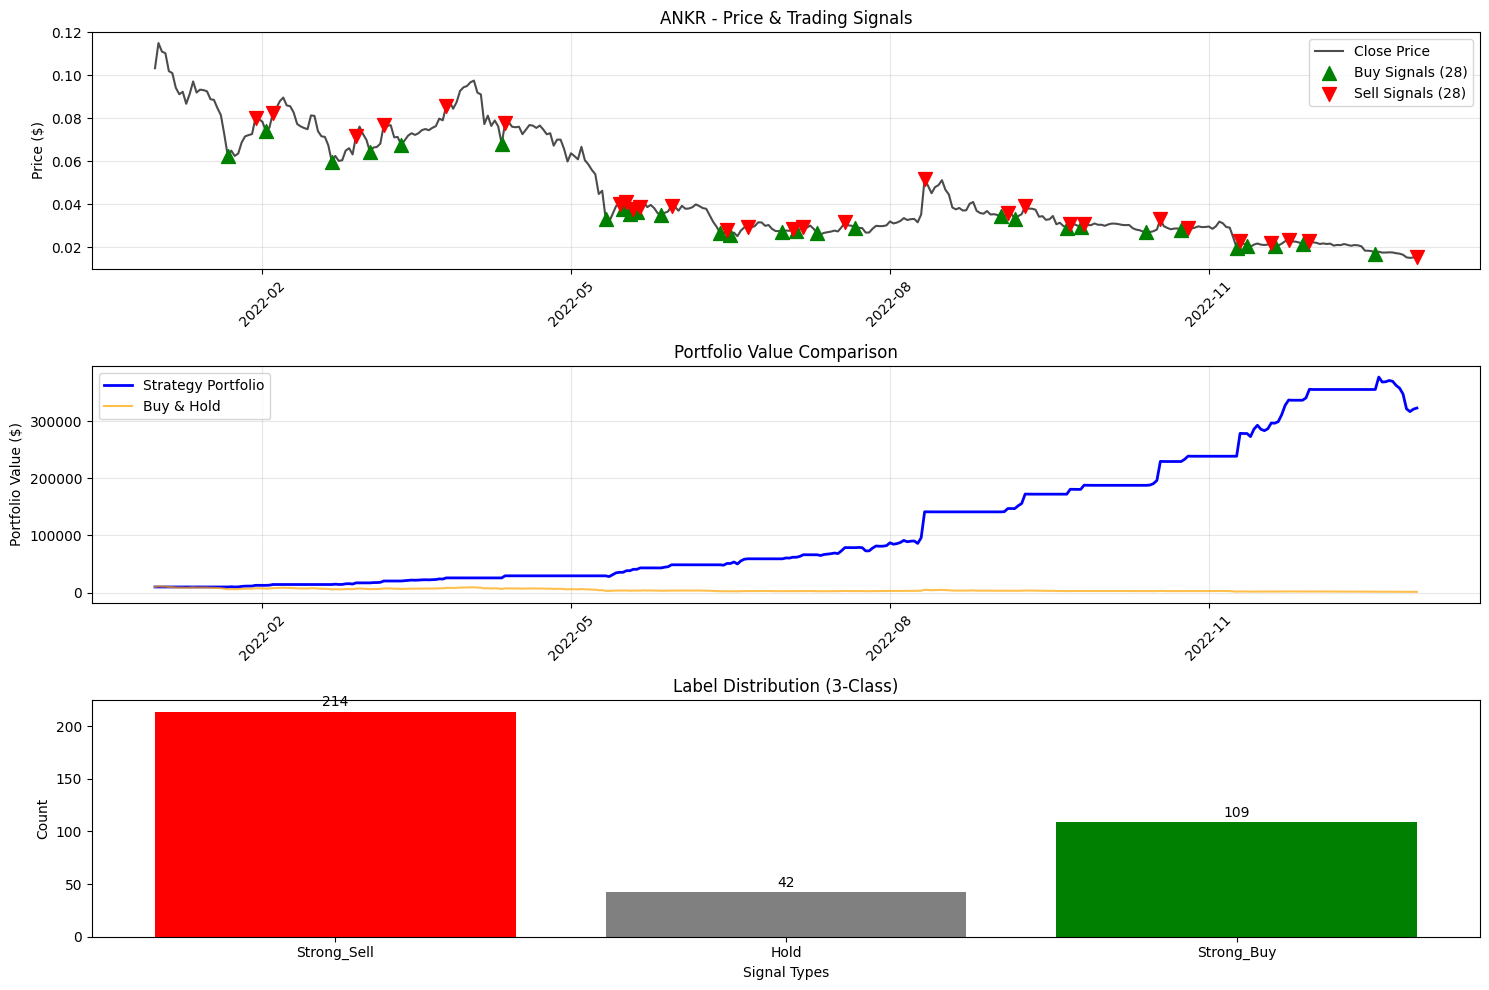


API3 백테스팅 결과:
전략 수익률: 12211.22%
Buy & Hold 수익률: -76.66%
초과 수익률: 12287.88%
샤프 비율: 5.05
최대 손실폭: -11.31%
총 거래 횟수: 72회
승률: 97.22%
평균 거래수익률: 15.52%
최종 자산: $1,231,122


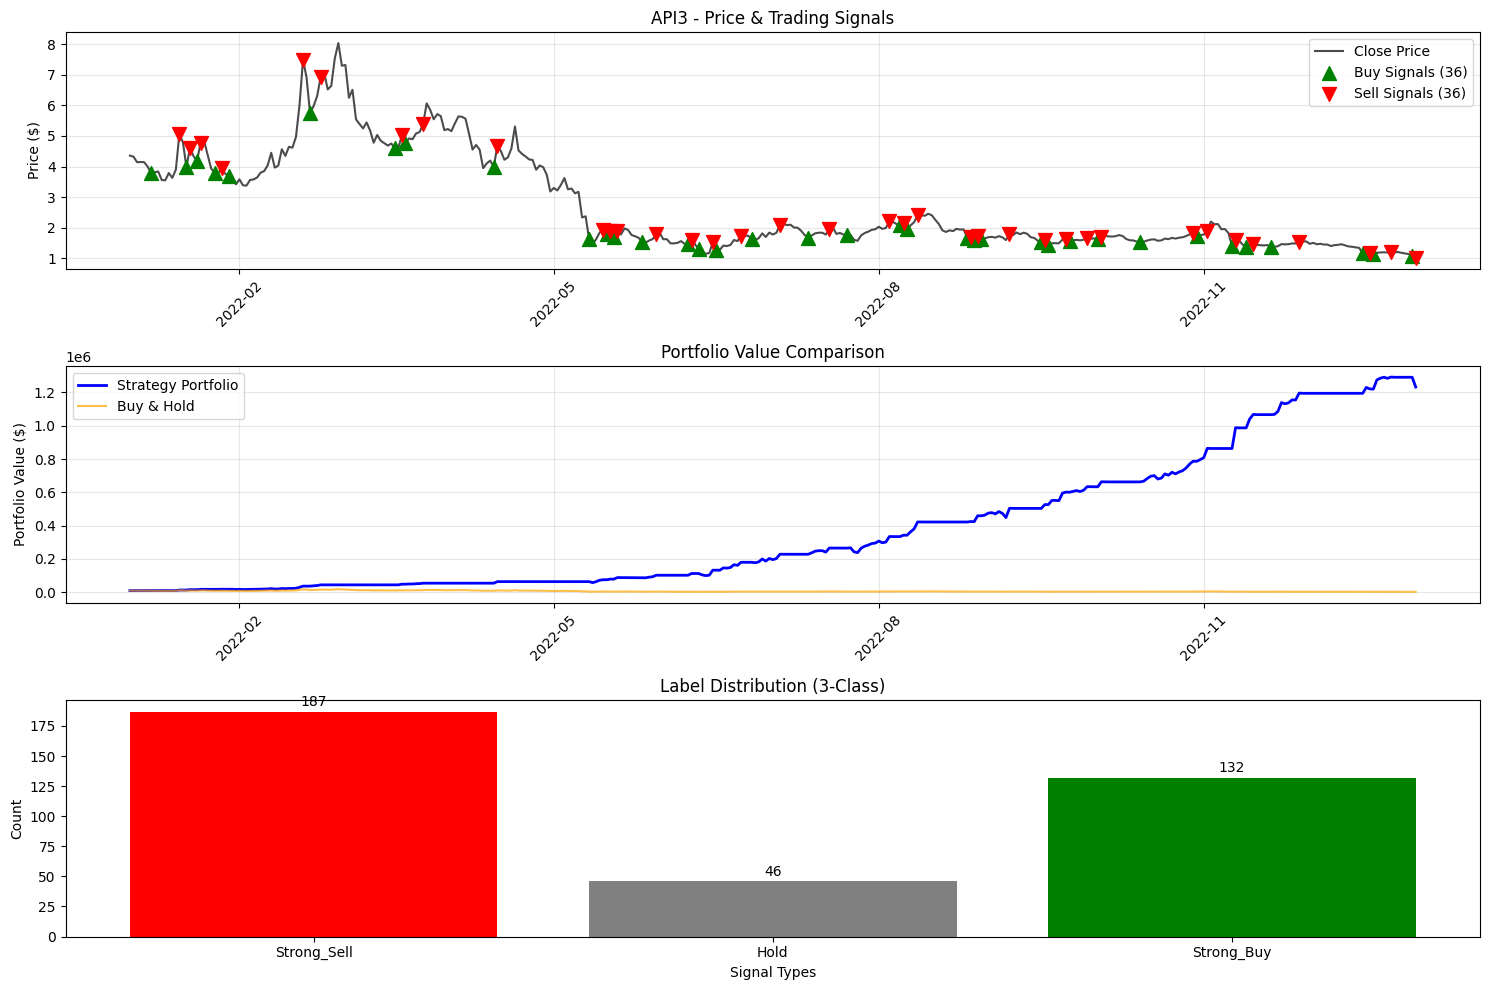


ASTR 백테스팅 결과:
전략 수익률: 3523.12%
Buy & Hold 수익률: -78.61%
초과 수익률: 3601.73%
샤프 비율: 4.02
최대 손실폭: -19.07%
총 거래 횟수: 50회
승률: 100.00%
평균 거래수익률: 17.63%
최종 자산: $362,312


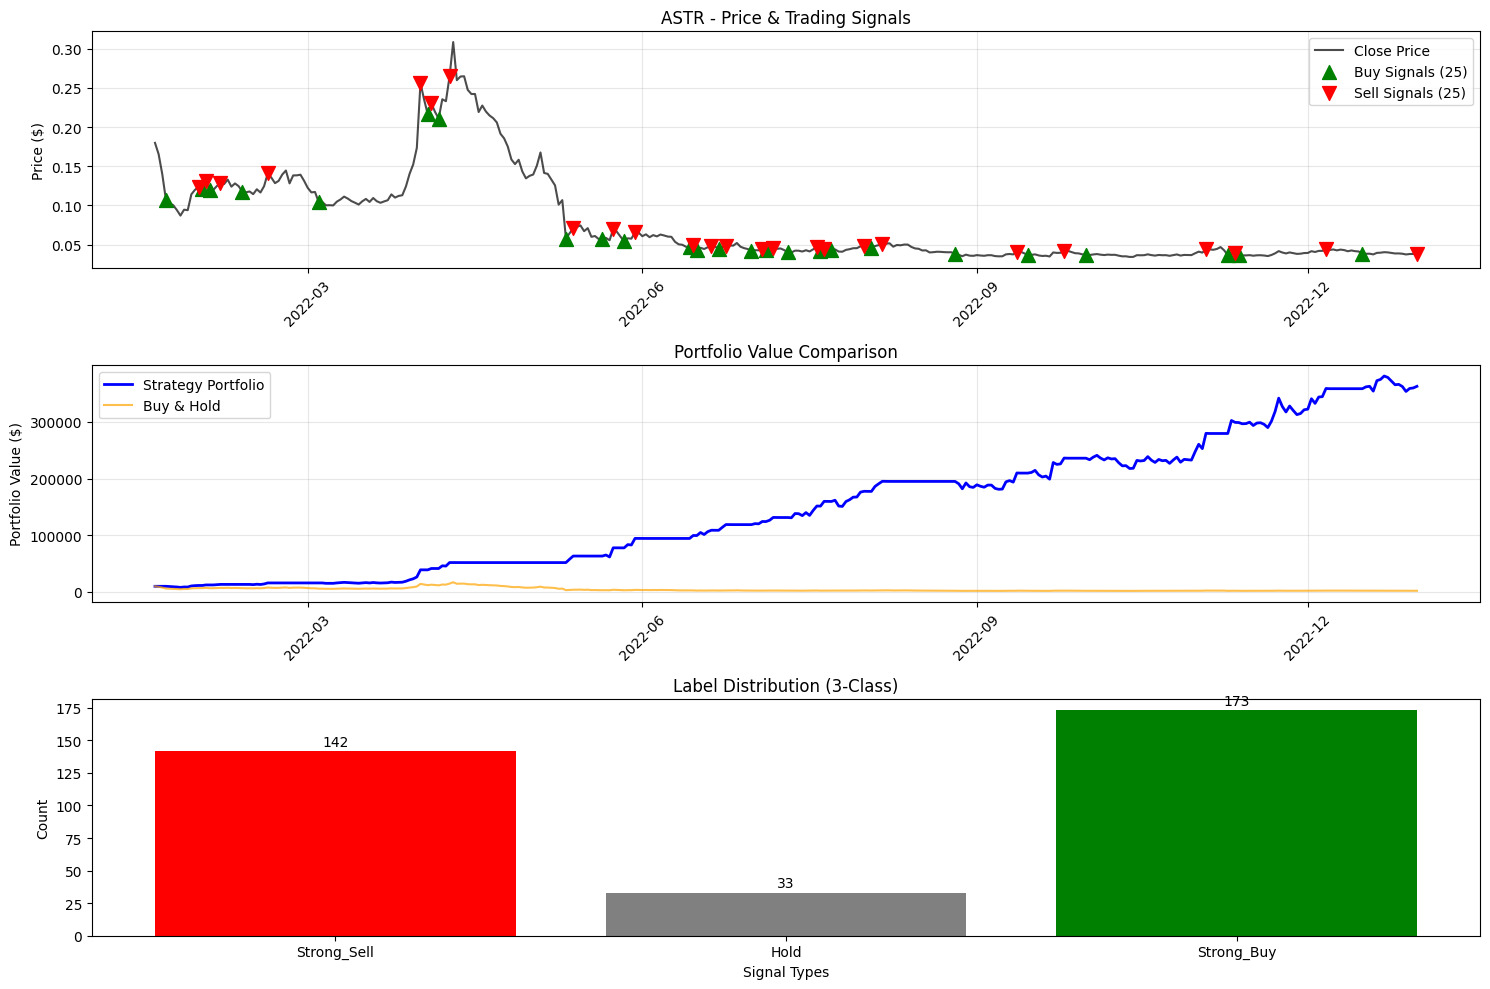


ATOM 백테스팅 결과:
전략 수익률: 4629.08%
Buy & Hold 수익률: -74.15%
초과 수익률: 4703.23%
샤프 비율: 4.93
최대 손실폭: -16.75%
총 거래 횟수: 58회
승률: 100.00%
평균 거래수익률: 14.89%
최종 자산: $472,908


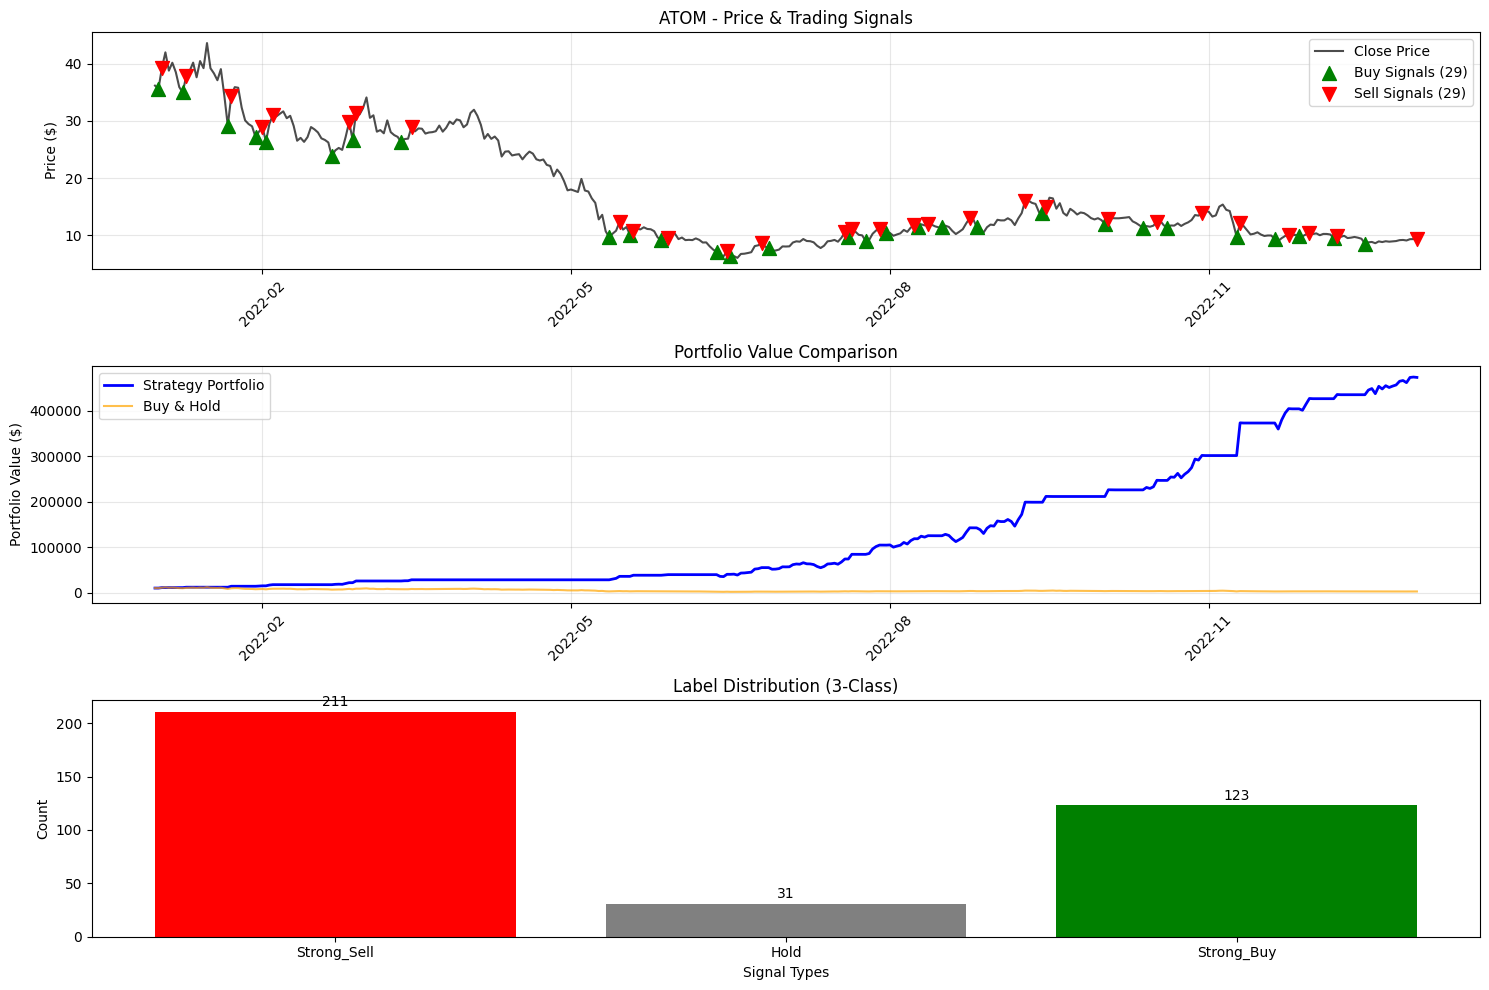


AVAX 백테스팅 결과:
전략 수익률: 1545.76%
Buy & Hold 수익률: -90.45%
초과 수익률: 1636.21%
샤프 비율: 4.21
최대 손실폭: -9.17%
총 거래 횟수: 42회
승률: 95.24%
평균 거래수익률: 14.98%
최종 자산: $164,576


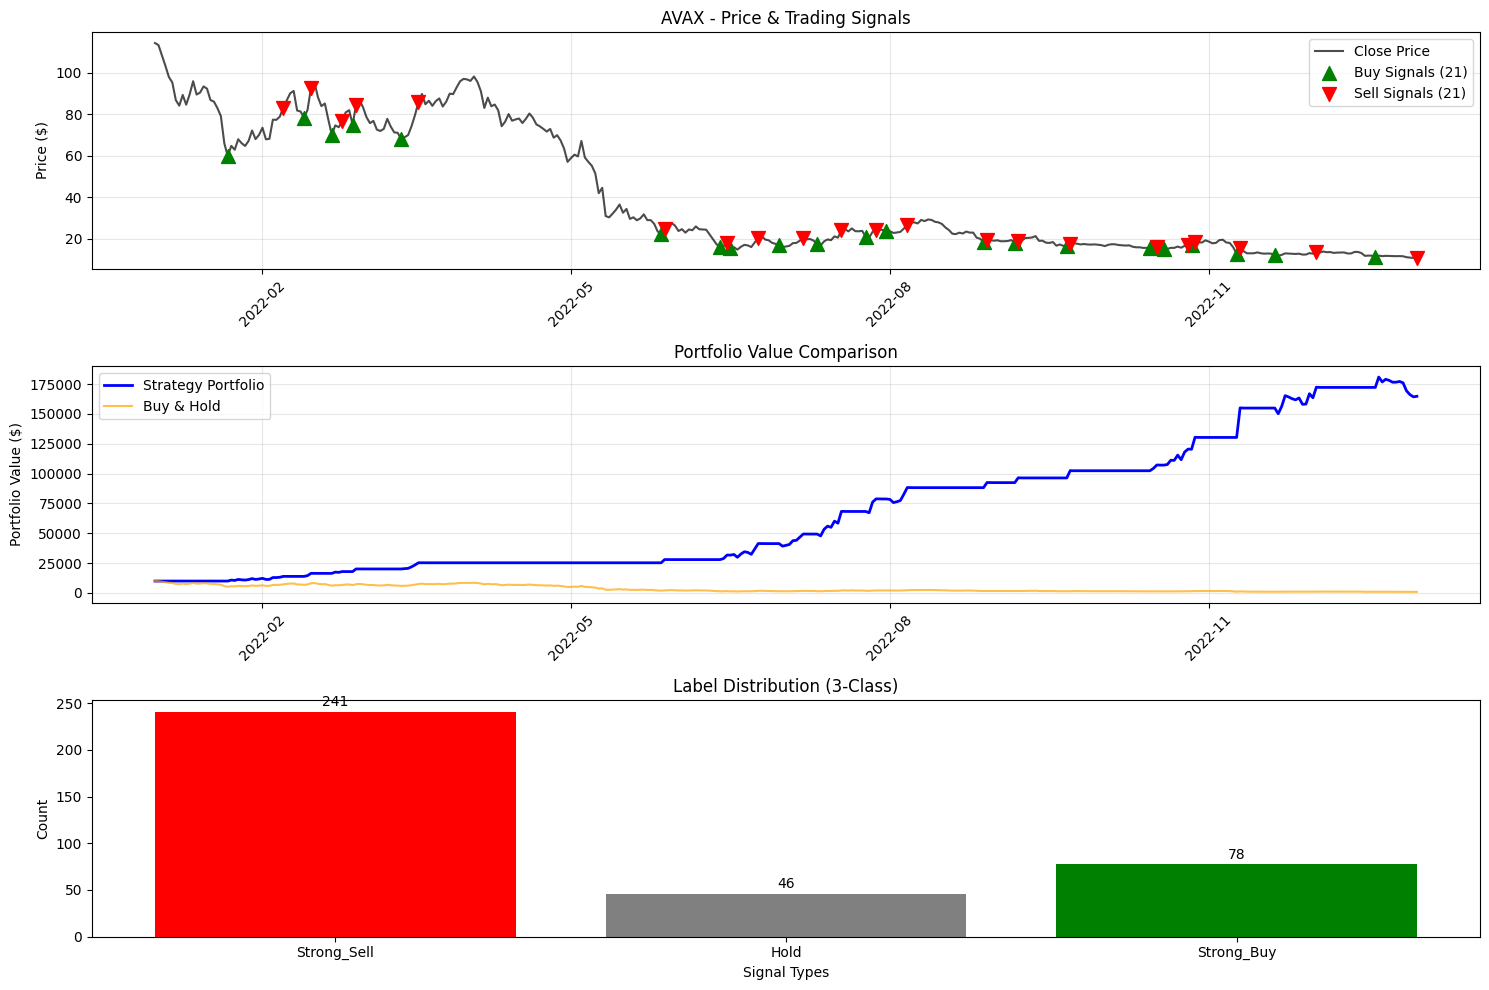


AXS 백테스팅 결과:
전략 수익률: 2906.82%
Buy & Hold 수익률: -93.58%
초과 수익률: 3000.39%
샤프 비율: 4.09
최대 손실폭: -10.09%
총 거래 횟수: 50회
승률: 96.00%
평균 거래수익률: 15.49%
최종 자산: $300,682


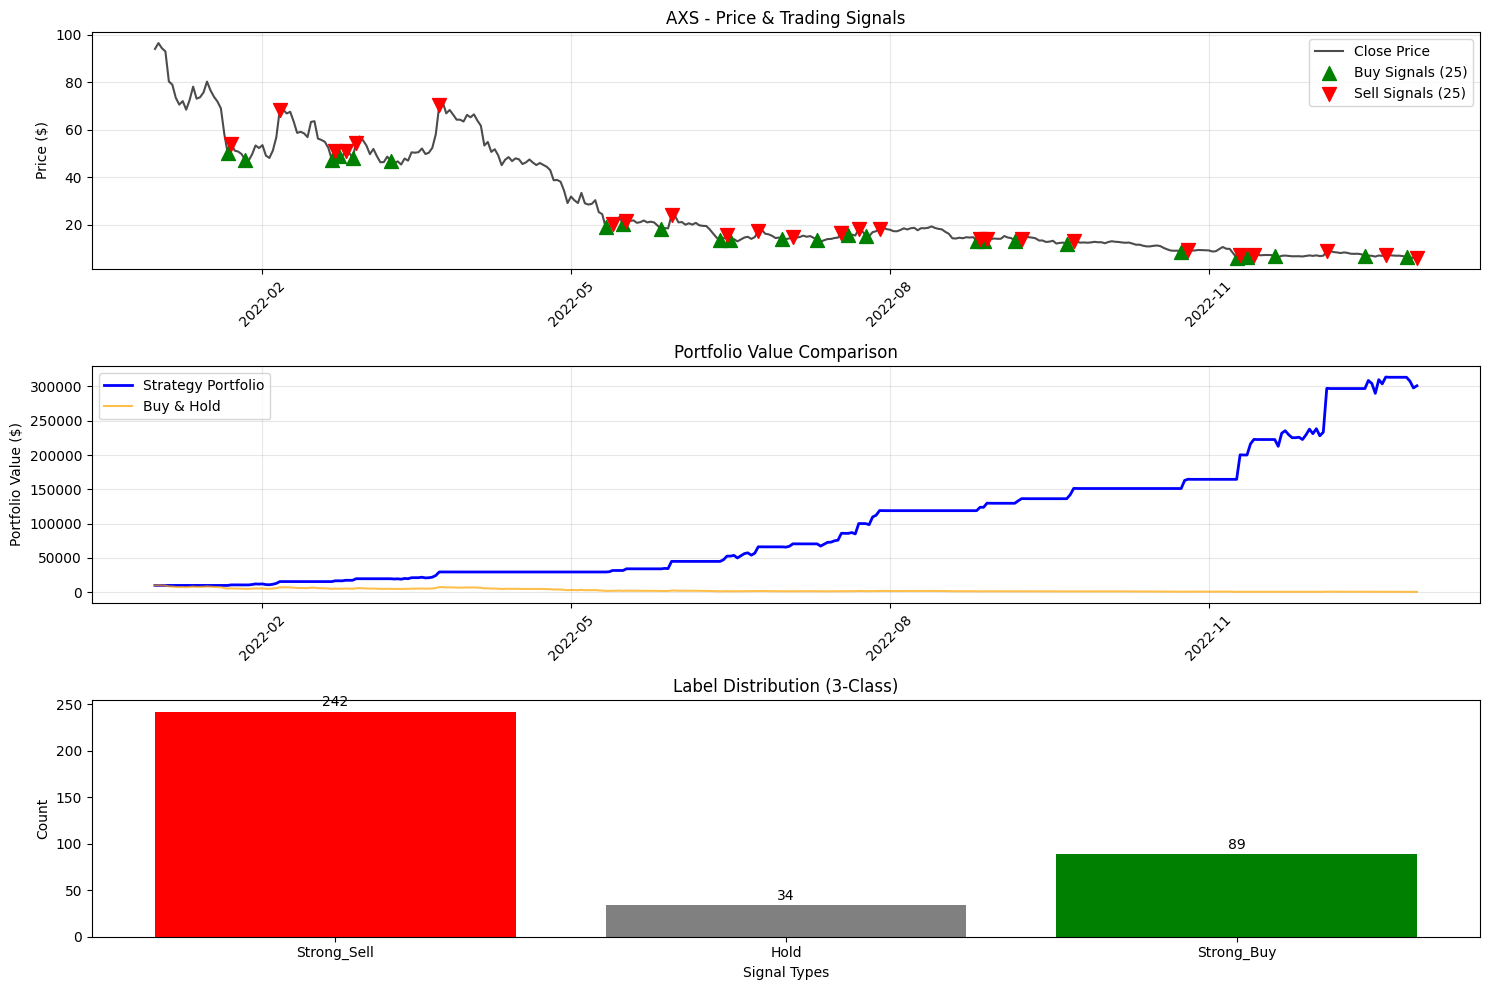


전체 백테스팅 결과 요약:
Symbol  Total_Return  Buy_Hold_Return  Excess_Return  Sharpe_Ratio  Max_Drawdown  Win_Rate  Num_Trades
 1INCH        13.550           -0.848         14.398         4.545        -0.087     0.970          66
  AAVE        57.570           -0.804         58.374         4.628        -0.140     0.968          62
   ADA        11.643           -0.821         12.464         4.422        -0.080     0.964          56
  ALGO         9.240           -0.901         10.141         4.670        -0.059     1.000          46
  ANKR        31.242           -0.852         32.094         4.269        -0.160     0.964          56
  API3       122.112           -0.767        122.879         5.052        -0.113     0.972          72
  ASTR        35.231           -0.786         36.017         4.021        -0.191     1.000          50
  ATOM        46.291           -0.742         47.032         4.926        -0.167     1.000          58
  AVAX        15.458           -0.904         16.362     

100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


로딩 완료: 99개 종목

Backtesting Period: 2023-01-01 to 2023-12-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

1INCH 백테스팅 결과:
전략 수익률: 1992.55%
Buy & Hold 수익률: 10.55%
초과 수익률: 1982.00%
샤프 비율: 5.37
최대 손실폭: -13.40%
총 거래 횟수: 42회
승률: 95.24%
평균 거래수익률: 16.70%
최종 자산: $209,255


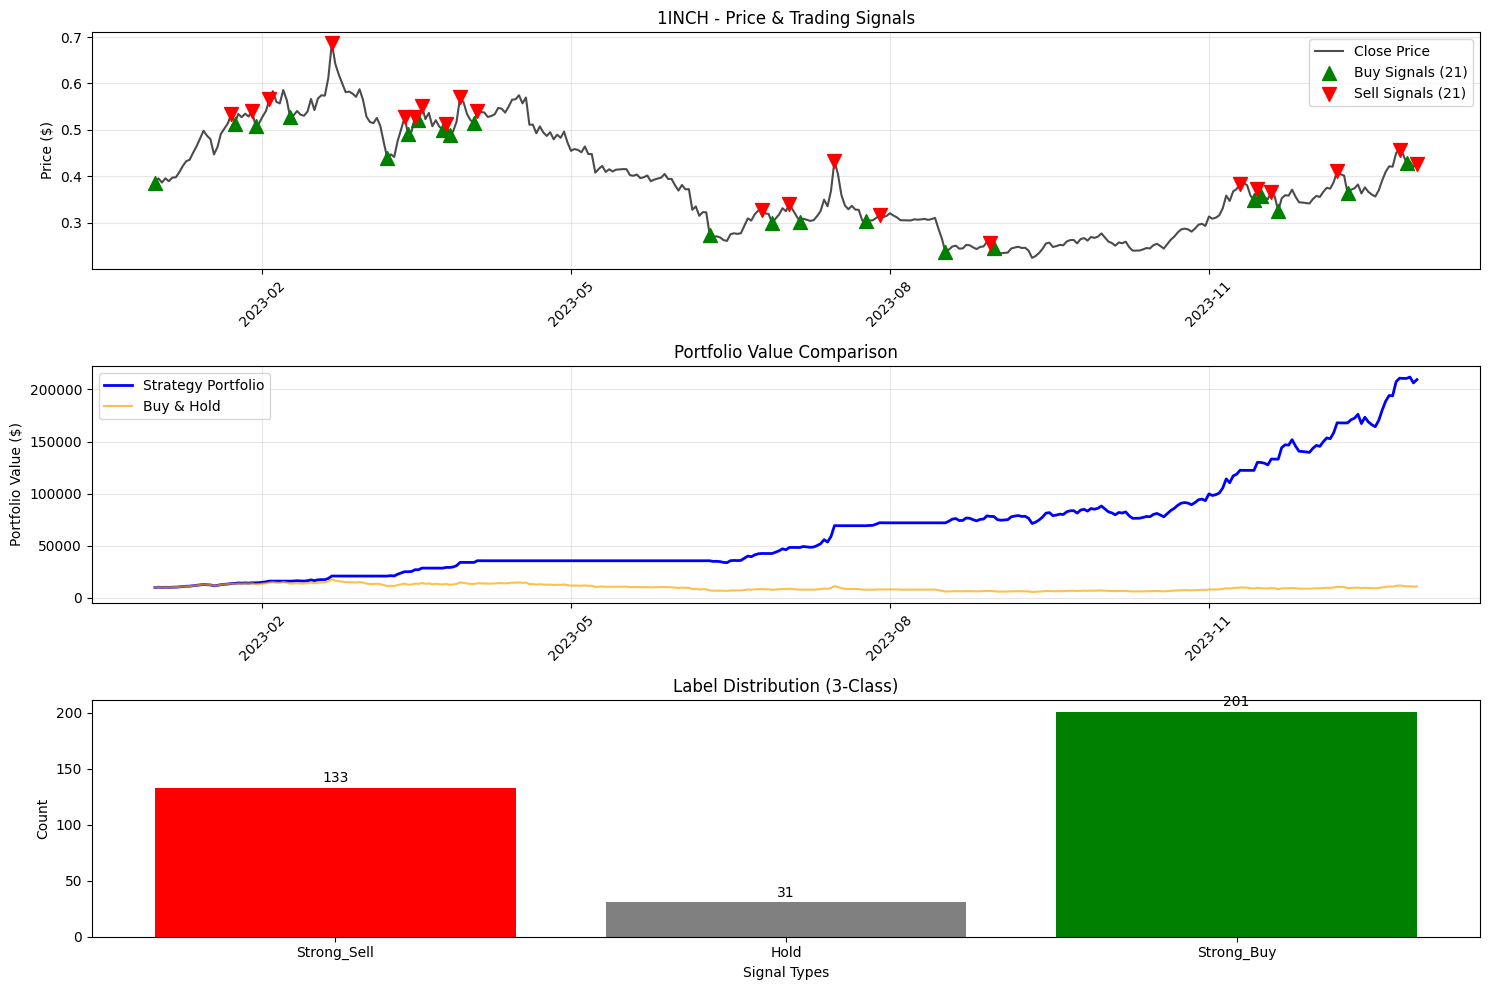


AAVE 백테스팅 결과:
전략 수익률: 2521.92%
Buy & Hold 수익률: 109.54%
초과 수익률: 2412.38%
샤프 비율: 5.32
최대 손실폭: -8.92%
총 거래 횟수: 52회
승률: 100.00%
평균 거래수익률: 14.19%
최종 자산: $262,192


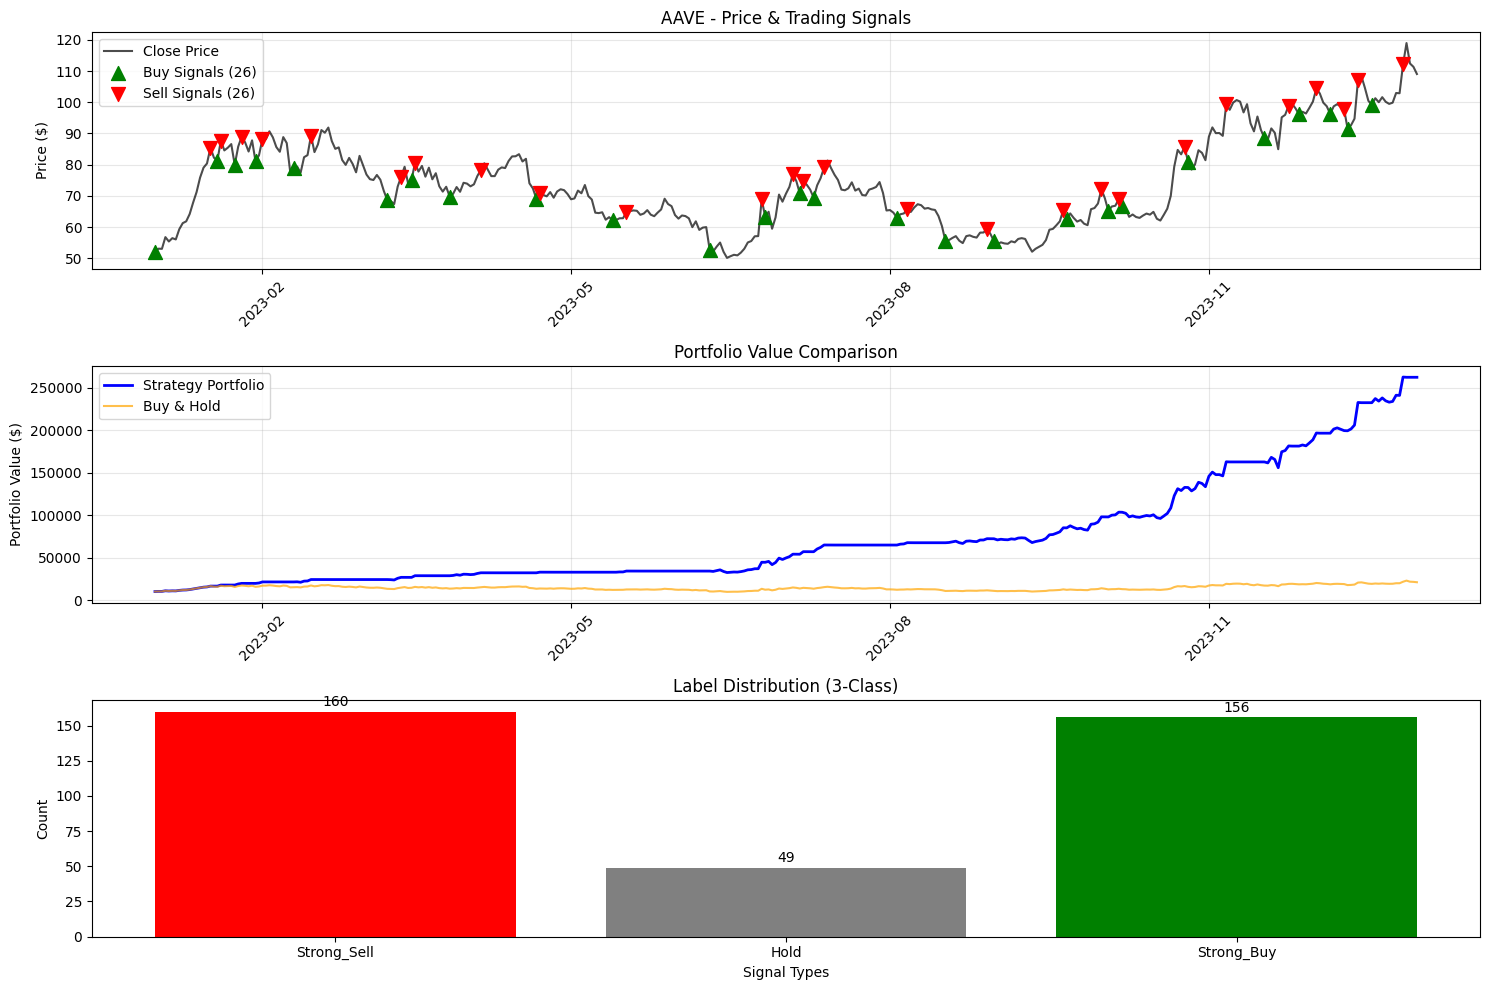


ADA 백테스팅 결과:
전략 수익률: 1549.95%
Buy & Hold 수익률: 137.90%
초과 수익률: 1412.05%
샤프 비율: 4.54
최대 손실폭: -8.44%
총 거래 횟수: 38회
승률: 100.00%
평균 거래수익률: 19.36%
최종 자산: $164,995


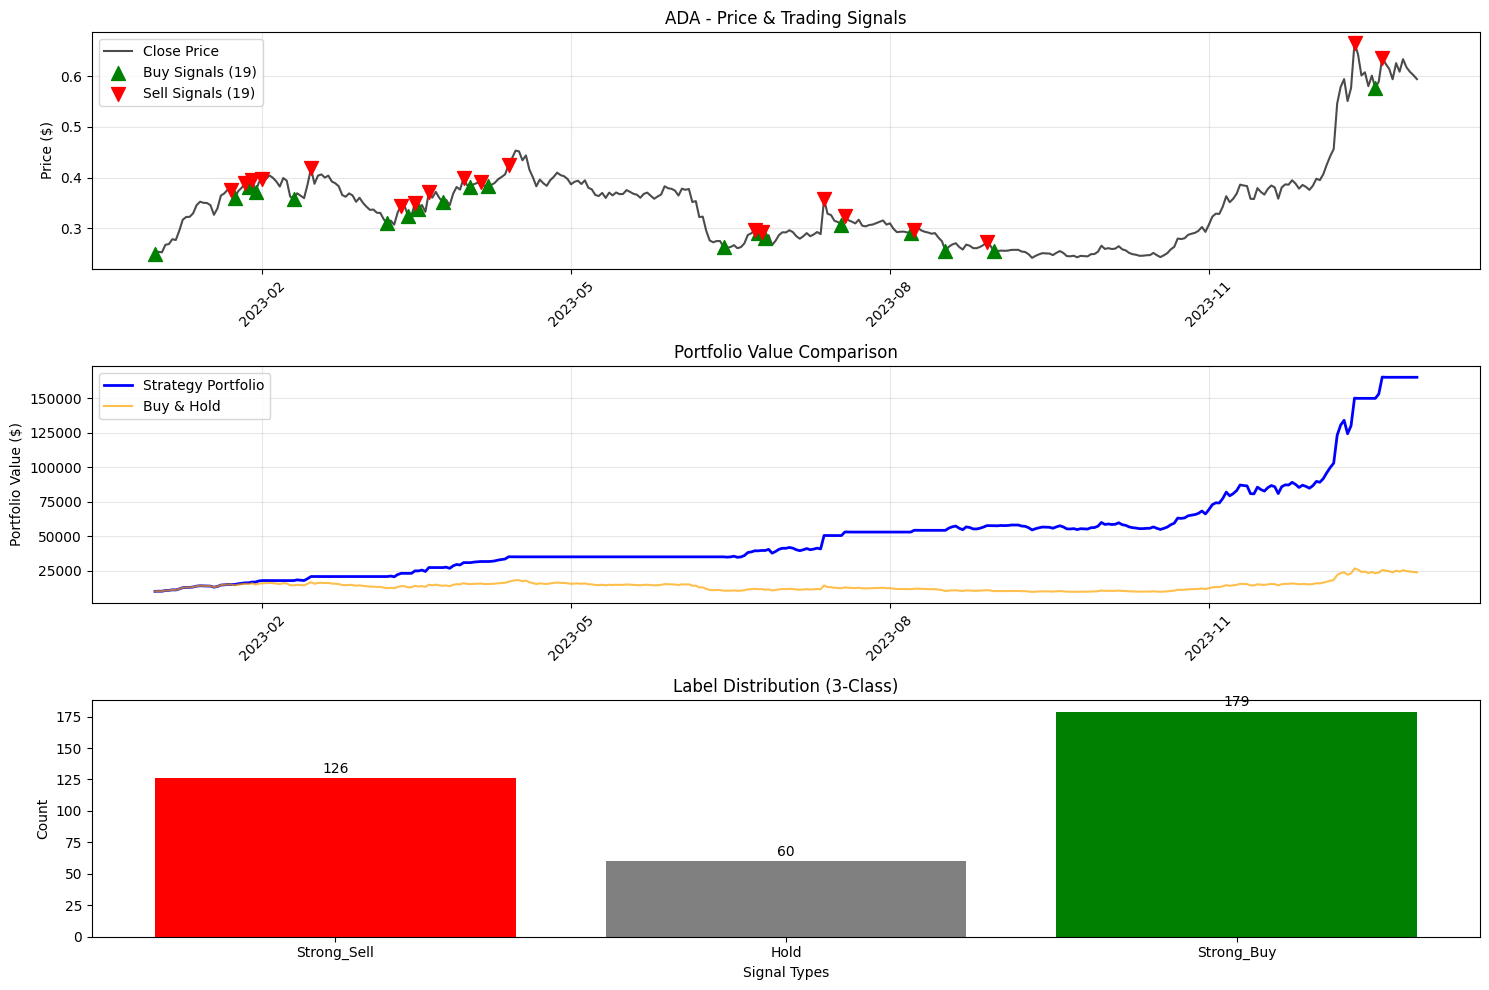


ALGO 백테스팅 결과:
전략 수익률: 1773.02%
Buy & Hold 수익률: 25.53%
초과 수익률: 1747.49%
샤프 비율: 5.09
최대 손실폭: -15.67%
총 거래 횟수: 38회
승률: 100.00%
평균 거래수익률: 18.07%
최종 자산: $187,302


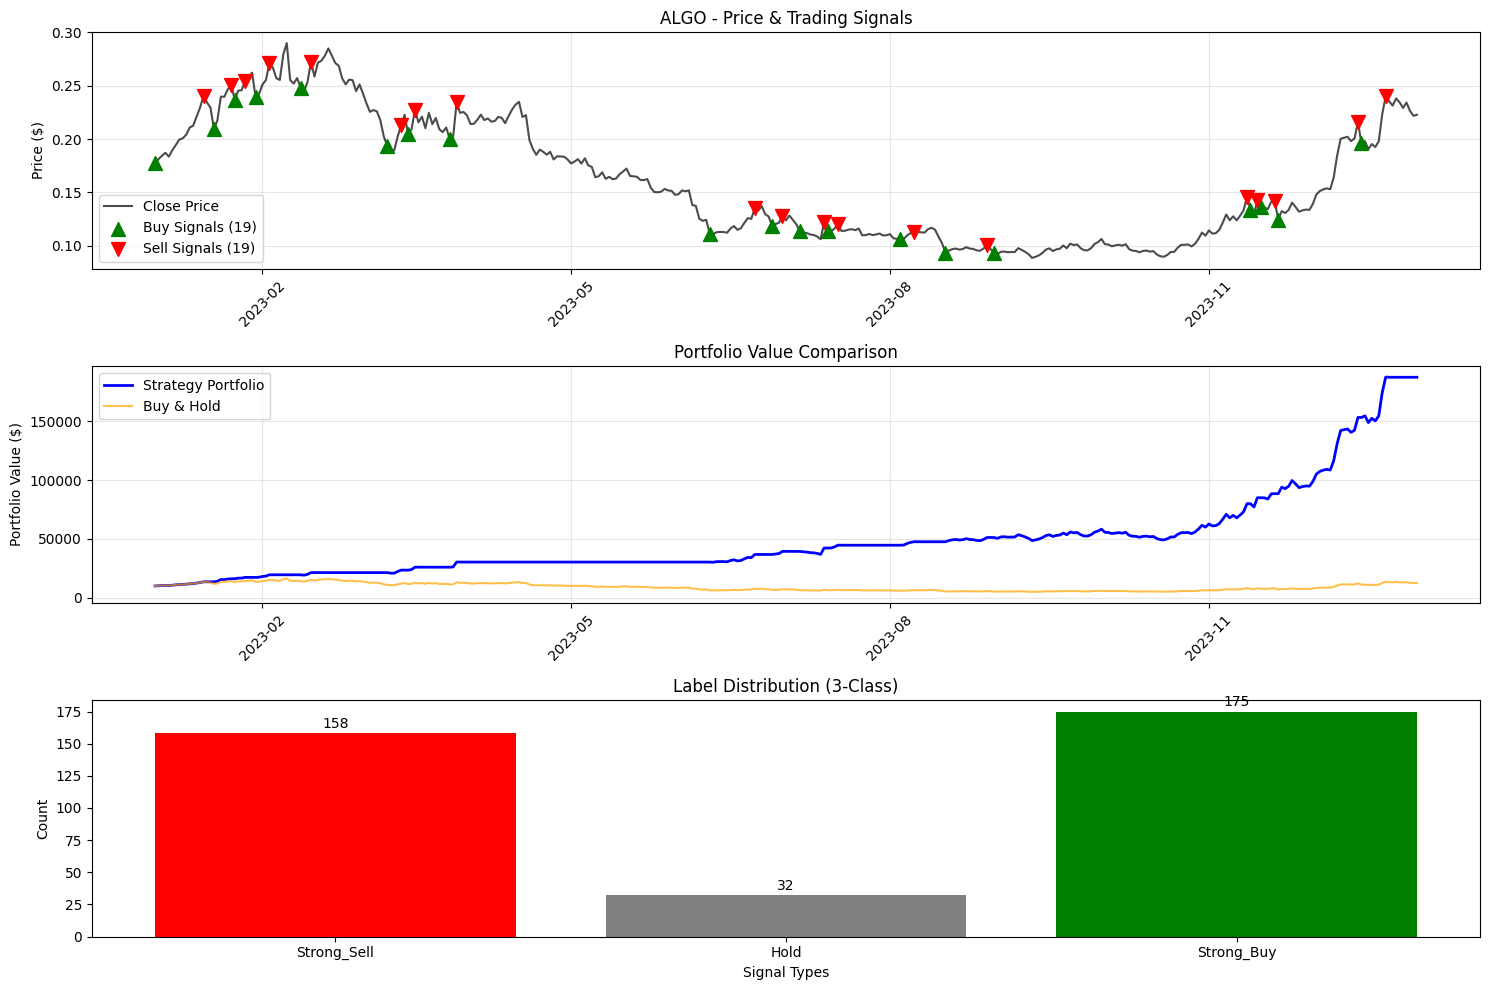


ANKR 백테스팅 결과:
전략 수익률: 1758.79%
Buy & Hold 수익률: 82.18%
초과 수익률: 1676.61%
샤프 비율: 4.12
최대 손실폭: -10.82%
총 거래 횟수: 30회
승률: 100.00%
평균 거래수익률: 26.92%
최종 자산: $185,879


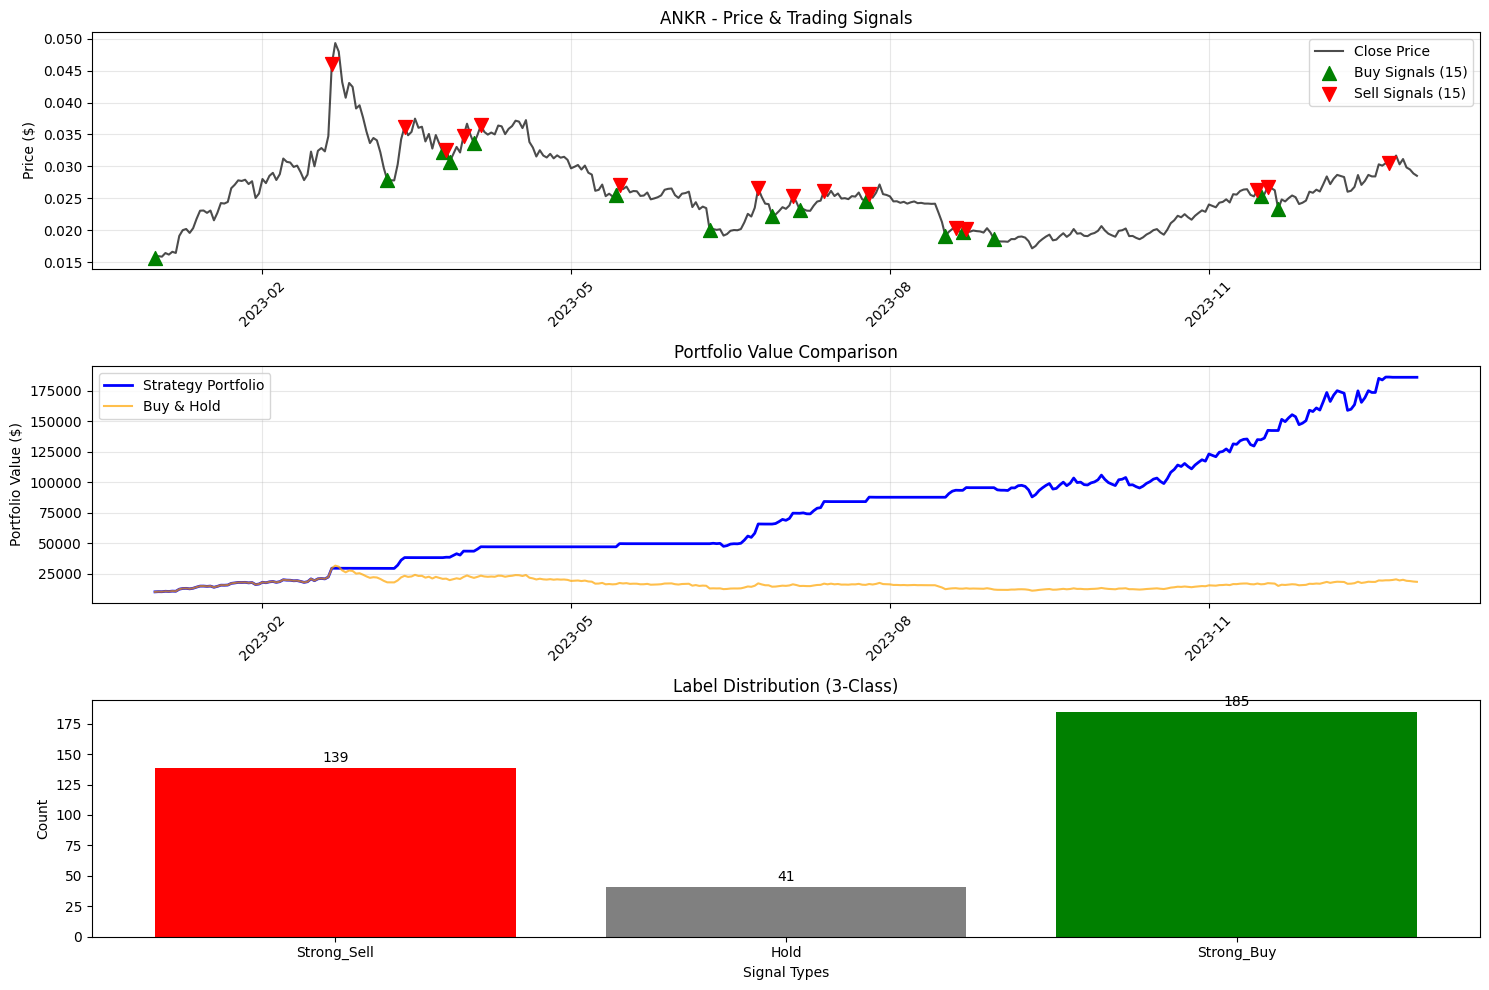


API3 백테스팅 결과:
전략 수익률: 4434.70%
Buy & Hold 수익률: 97.38%
초과 수익률: 4337.32%
샤프 비율: 3.82
최대 손실폭: -14.72%
총 거래 횟수: 60회
승률: 100.00%
평균 거래수익률: 14.60%
최종 자산: $453,470


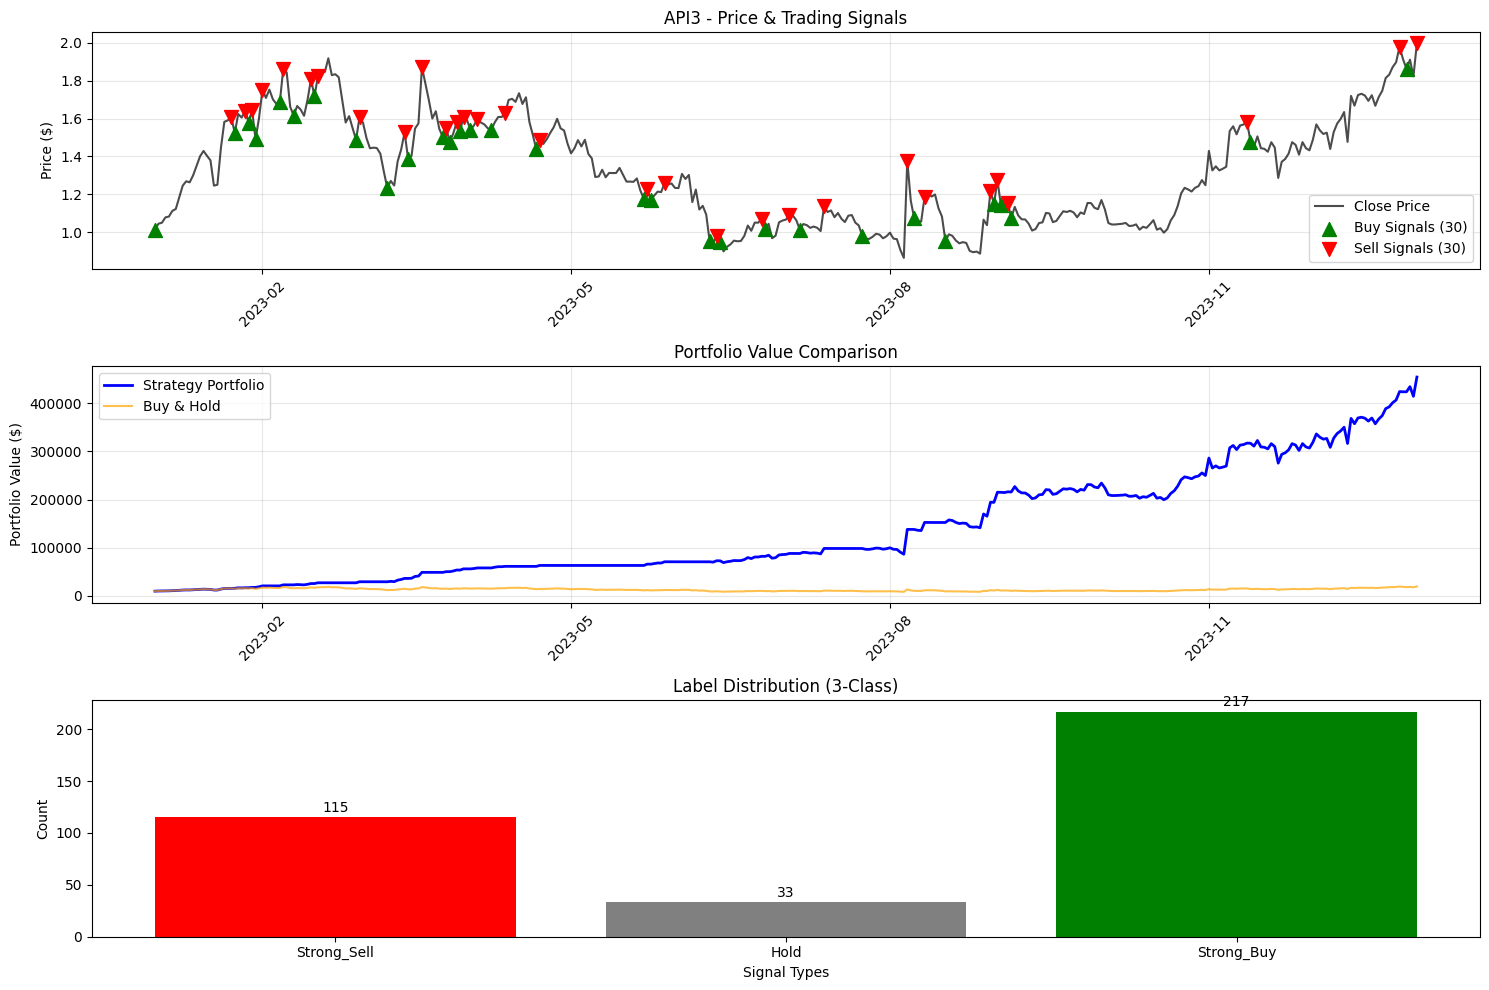


APT21794 백테스팅 결과:
전략 수익률: 5328.63%
Buy & Hold 수익률: 166.66%
초과 수익률: 5161.96%
샤프 비율: 3.92
최대 손실폭: -14.77%
총 거래 횟수: 52회
승률: 96.15%
평균 거래수익률: 26.25%
최종 자산: $542,863


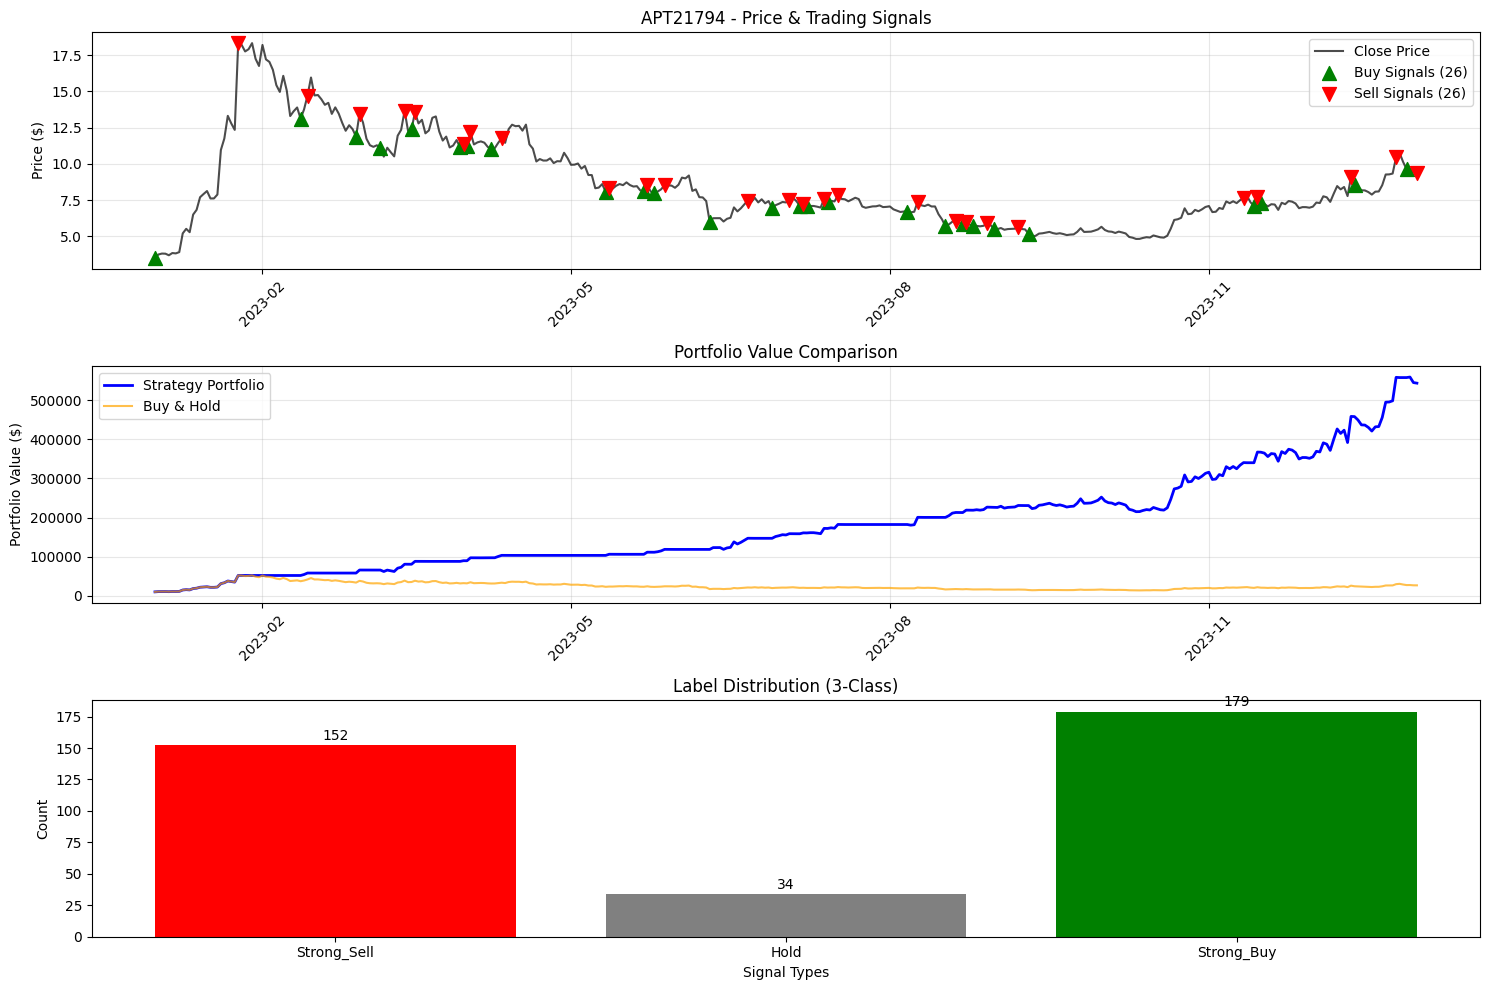


ARB11841 백테스팅 결과:
전략 수익률: 1004.89%
Buy & Hold 수익률: 16.84%
초과 수익률: 988.05%
샤프 비율: 4.03
최대 손실폭: -15.33%
총 거래 횟수: 38회
승률: 100.00%
평균 거래수익률: 14.41%
최종 자산: $110,489


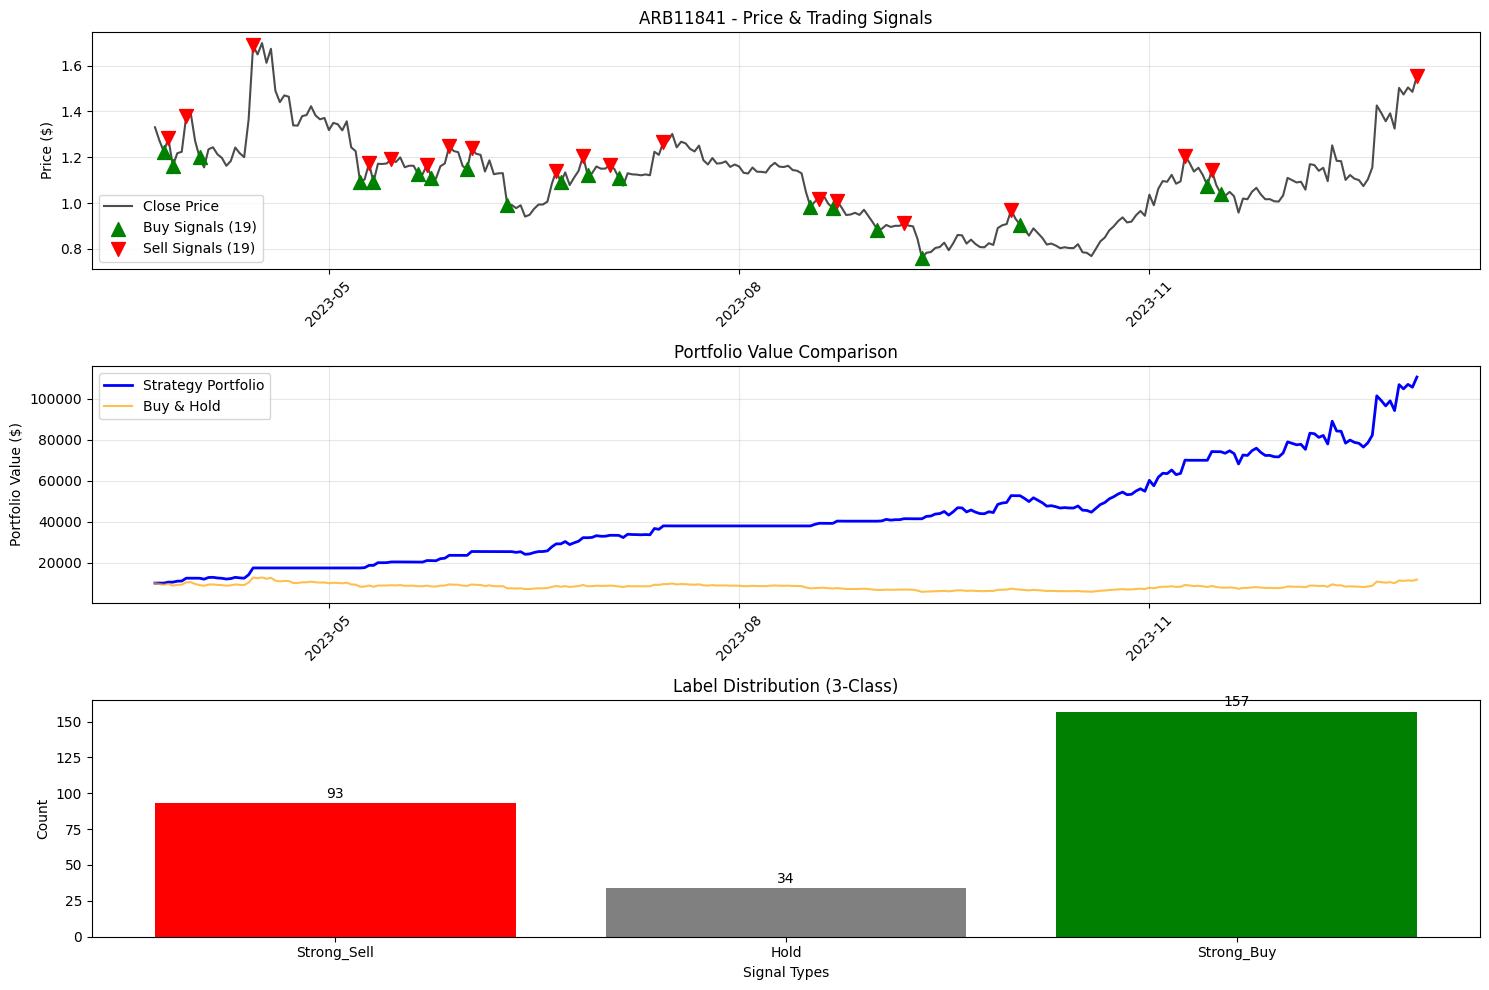


ASTR 백테스팅 결과:
전략 수익률: 4673.44%
Buy & Hold 수익률: 245.26%
초과 수익률: 4428.18%
샤프 비율: 4.43
최대 손실폭: -24.19%
총 거래 횟수: 38회
승률: 100.00%
평균 거래수익률: 27.09%
최종 자산: $477,344


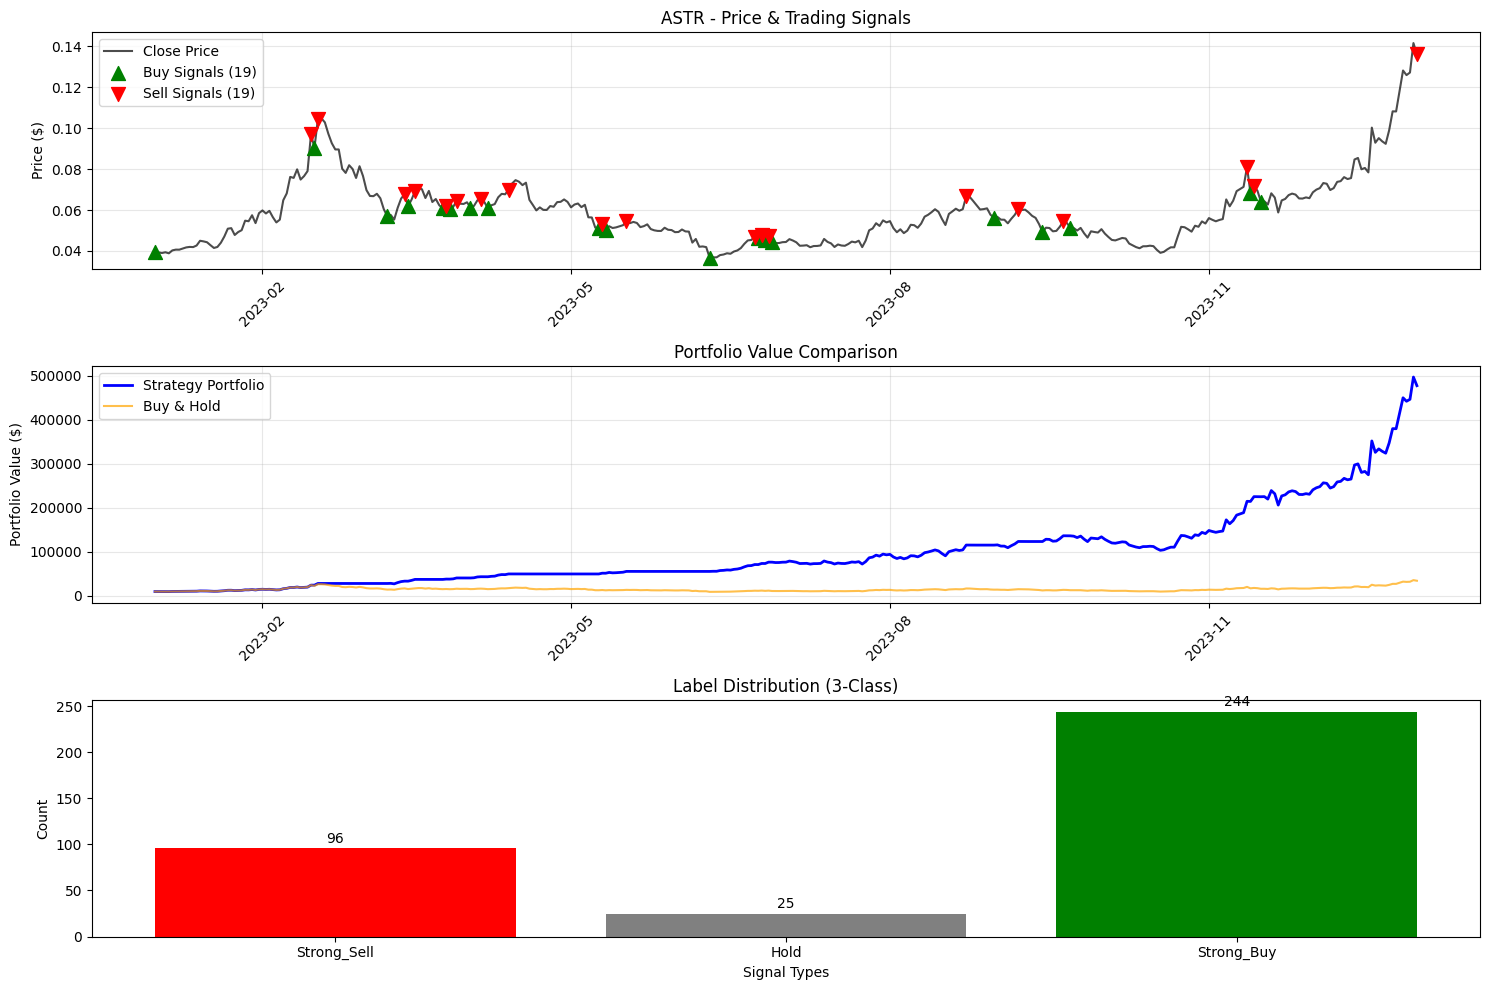


ATOM 백테스팅 결과:
전략 수익률: 1229.04%
Buy & Hold 수익률: 11.91%
초과 수익률: 1217.13%
샤프 비율: 4.99
최대 손실폭: -10.01%
총 거래 횟수: 50회
승률: 100.00%
평균 거래수익률: 11.53%
최종 자산: $132,904


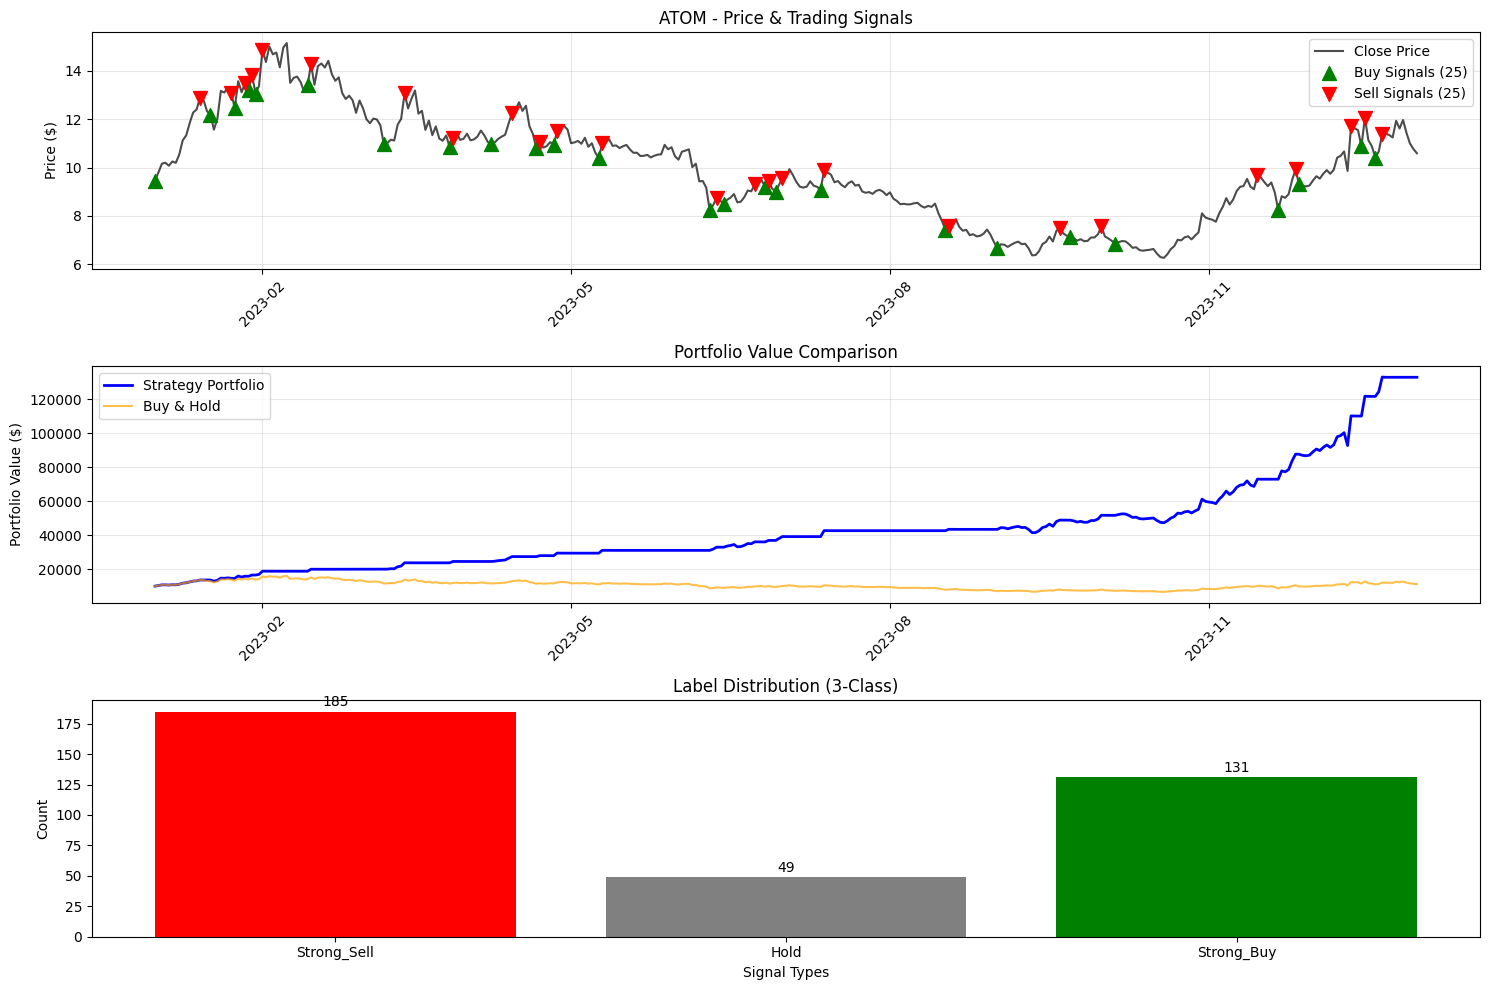


전체 백테스팅 결과 요약:
  Symbol  Total_Return  Buy_Hold_Return  Excess_Return  Sharpe_Ratio  Max_Drawdown  Win_Rate  Num_Trades
   1INCH        19.926            0.105         19.820         5.369        -0.134     0.952          42
    AAVE        25.219            1.095         24.124         5.316        -0.089     1.000          52
     ADA        15.499            1.379         14.120         4.542        -0.084     1.000          38
    ALGO        17.730            0.255         17.475         5.090        -0.157     1.000          38
    ANKR        17.588            0.822         16.766         4.122        -0.108     1.000          30
    API3        44.347            0.974         43.373         3.821        -0.147     1.000          60
APT21794        53.286            1.667         51.620         3.925        -0.148     0.962          52
ARB11841        10.049            0.168          9.881         4.029        -0.153     1.000          38
    ASTR        46.734            2.453

100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


로딩 완료: 100개 종목

Backtesting Period: 2024-01-01 to 2024-12-31
Initial Capital: $10,000
3-Class Label Strategy (0:Sell, 1:Hold, 2:Buy)
Running backtest for 10 stocks...

1INCH 백테스팅 결과:
전략 수익률: 4407.17%
Buy & Hold 수익률: -21.74%
초과 수익률: 4428.91%
샤프 비율: 4.99
최대 손실폭: -13.80%
총 거래 횟수: 60회
승률: 96.67%
평균 거래수익률: 15.17%
최종 자산: $450,717


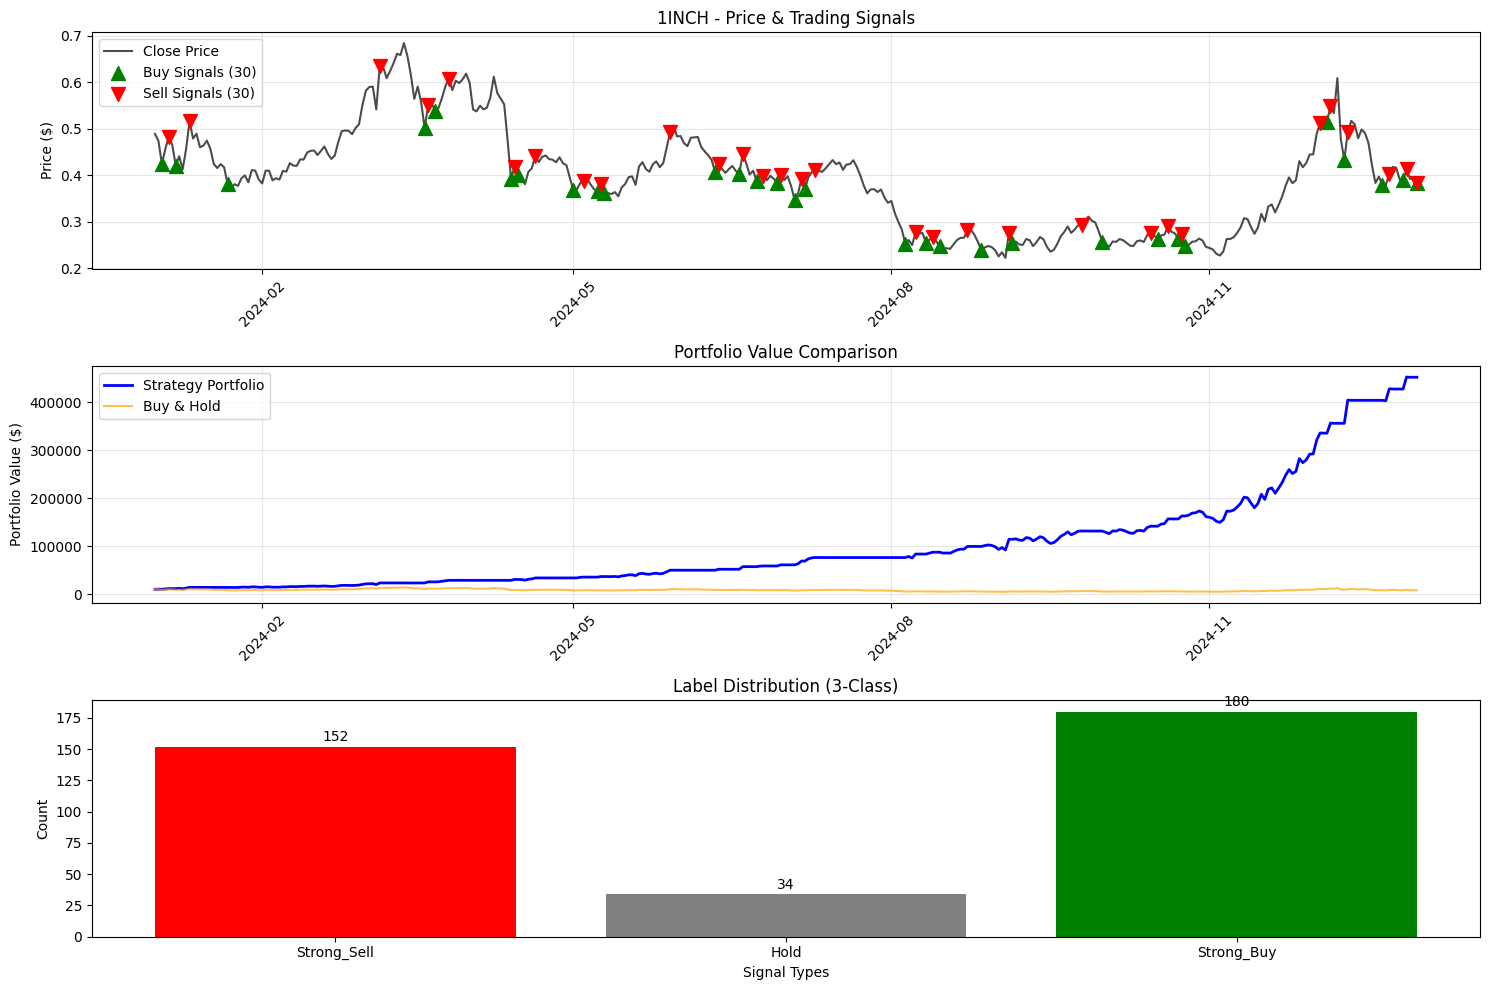


AAVE 백테스팅 결과:
전략 수익률: 5768.42%
Buy & Hold 수익률: 165.96%
초과 수익률: 5602.46%
샤프 비율: 4.53
최대 손실폭: -17.96%
총 거래 횟수: 52회
승률: 96.15%
평균 거래수익률: 18.82%
최종 자산: $586,842


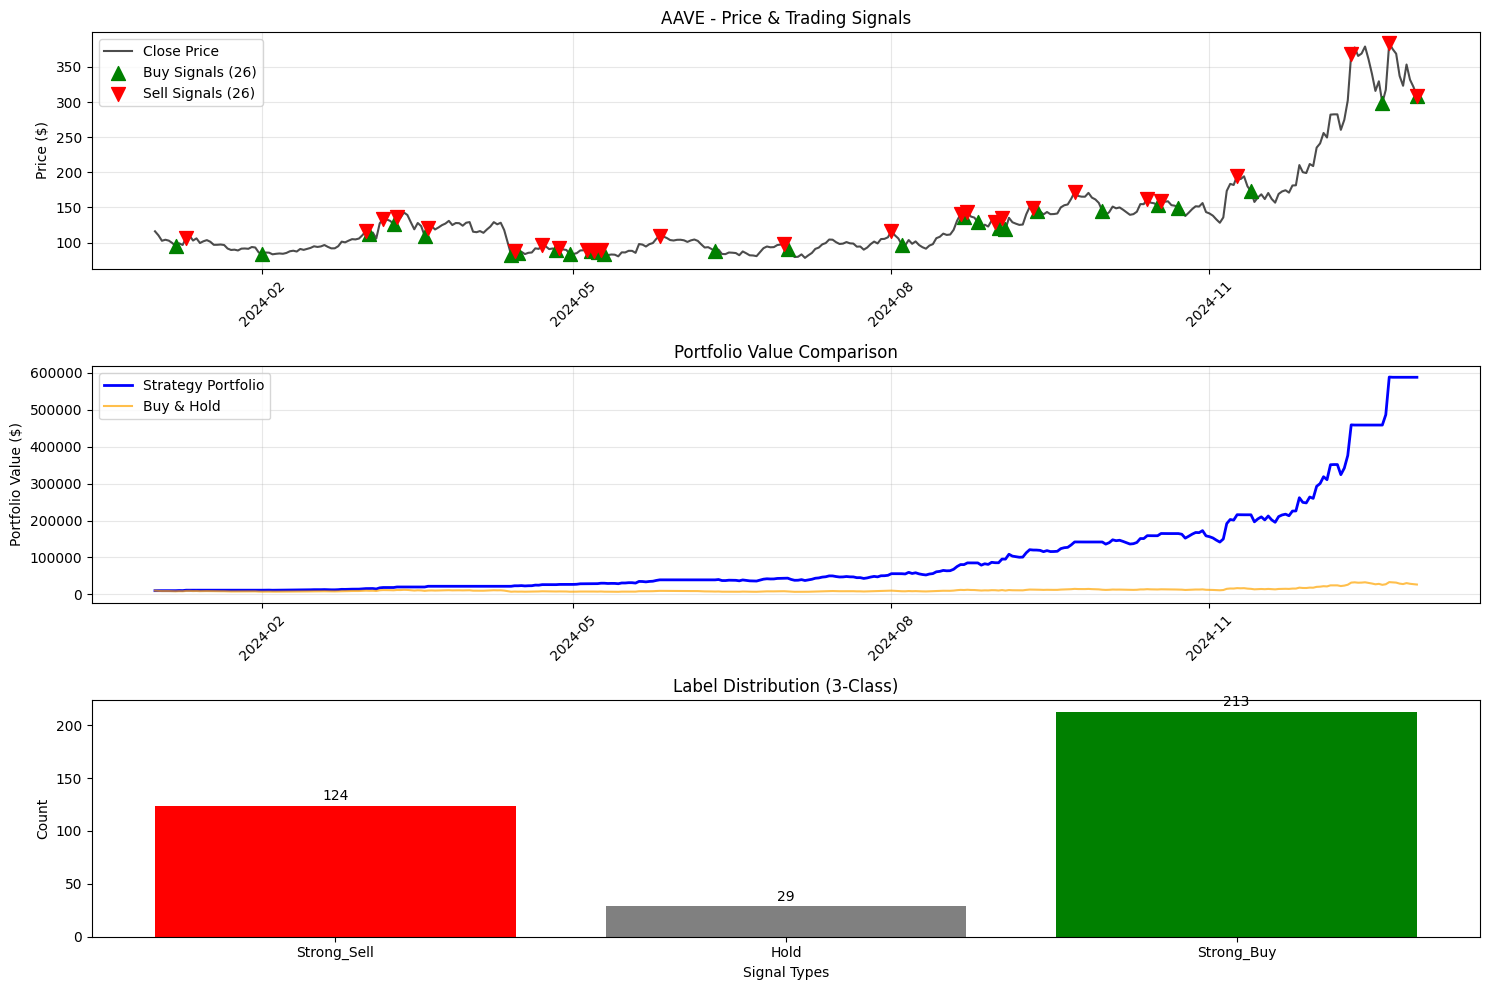


ADA 백테스팅 결과:
전략 수익률: 2706.44%
Buy & Hold 수익률: 35.41%
초과 수익률: 2671.03%
샤프 비율: 4.82
최대 손실폭: -14.41%
총 거래 횟수: 48회
승률: 95.83%
평균 거래수익률: 18.62%
최종 자산: $280,644


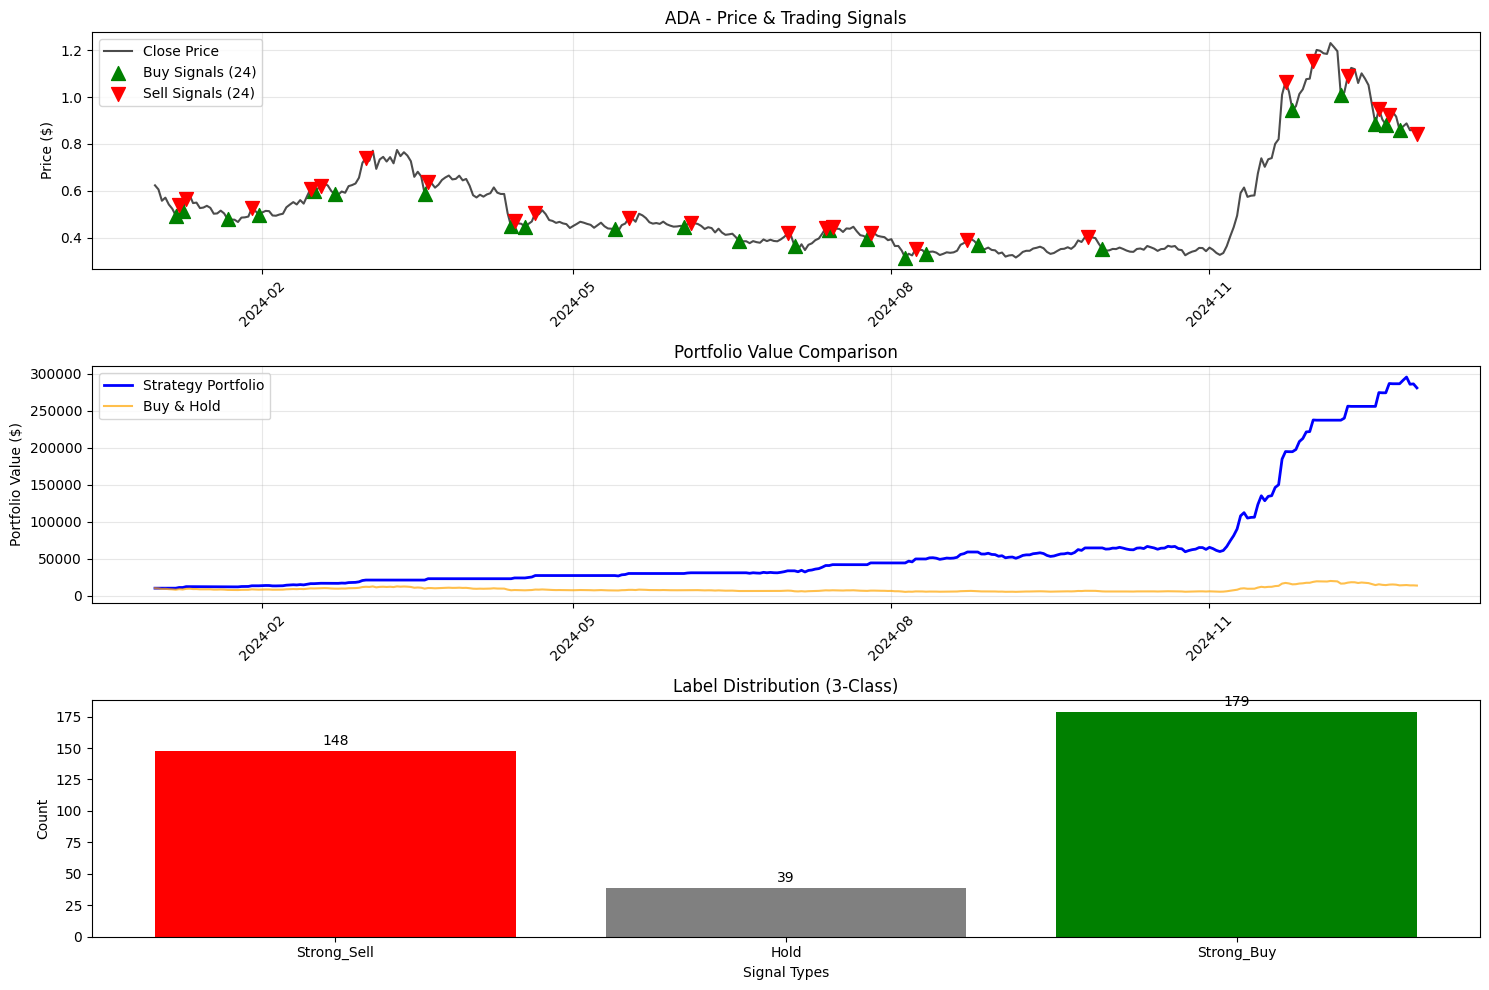


ALGO 백테스팅 결과:
전략 수익률: 3968.76%
Buy & Hold 수익률: 39.63%
초과 수익률: 3929.12%
샤프 비율: 4.21
최대 손실폭: -16.17%
총 거래 횟수: 46회
승률: 100.00%
평균 거래수익률: 24.35%
최종 자산: $406,876


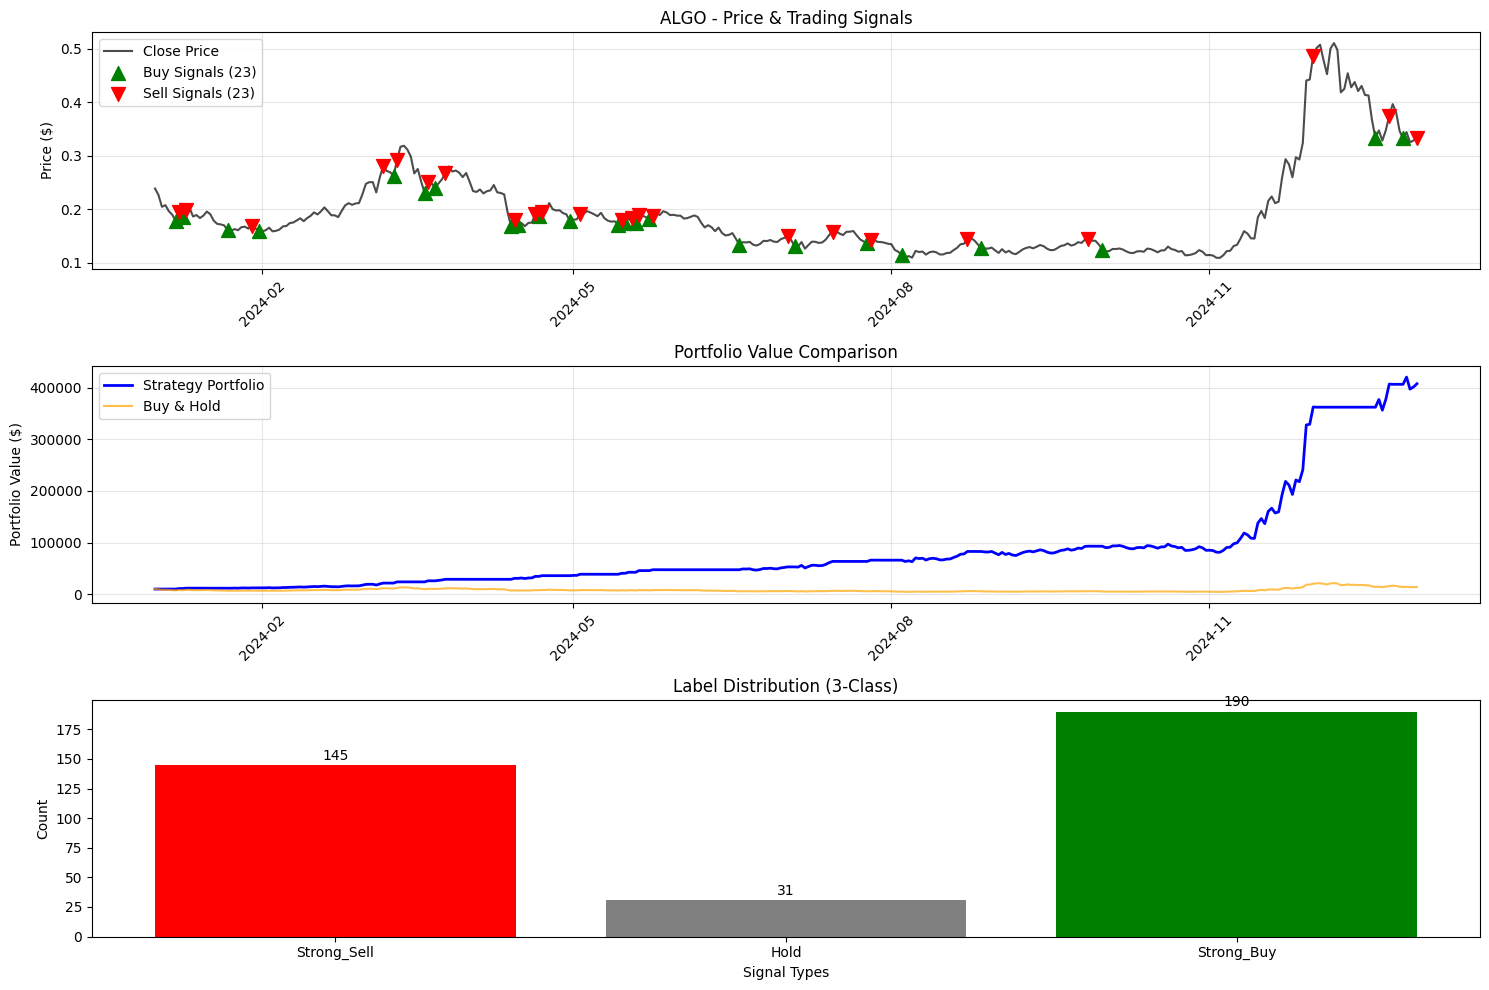


ANKR 백테스팅 결과:
전략 수익률: 4928.81%
Buy & Hold 수익률: 12.99%
초과 수익률: 4915.82%
샤프 비율: 5.52
최대 손실폭: -14.25%
총 거래 횟수: 50회
승률: 96.00%
평균 거래수익률: 19.53%
최종 자산: $502,881


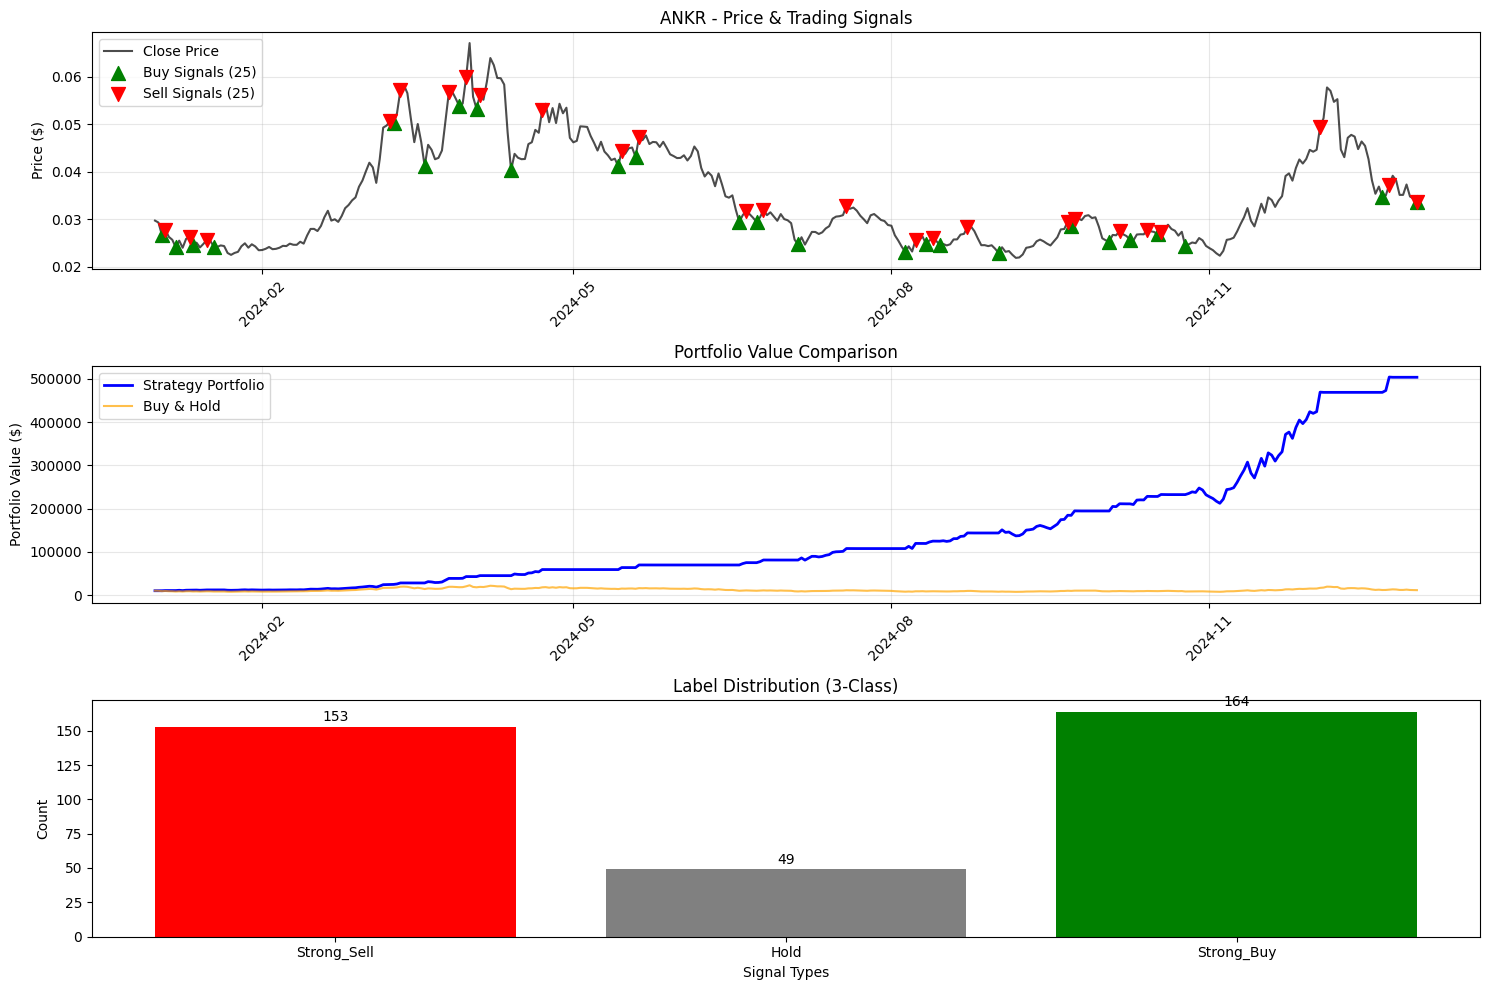


API3 백테스팅 결과:
전략 수익률: 13861.03%
Buy & Hold 수익률: -19.39%
초과 수익률: 13880.42%
샤프 비율: 4.08
최대 손실폭: -17.38%
총 거래 횟수: 60회
승률: 100.00%
평균 거래수익률: 18.89%
최종 자산: $1,396,103


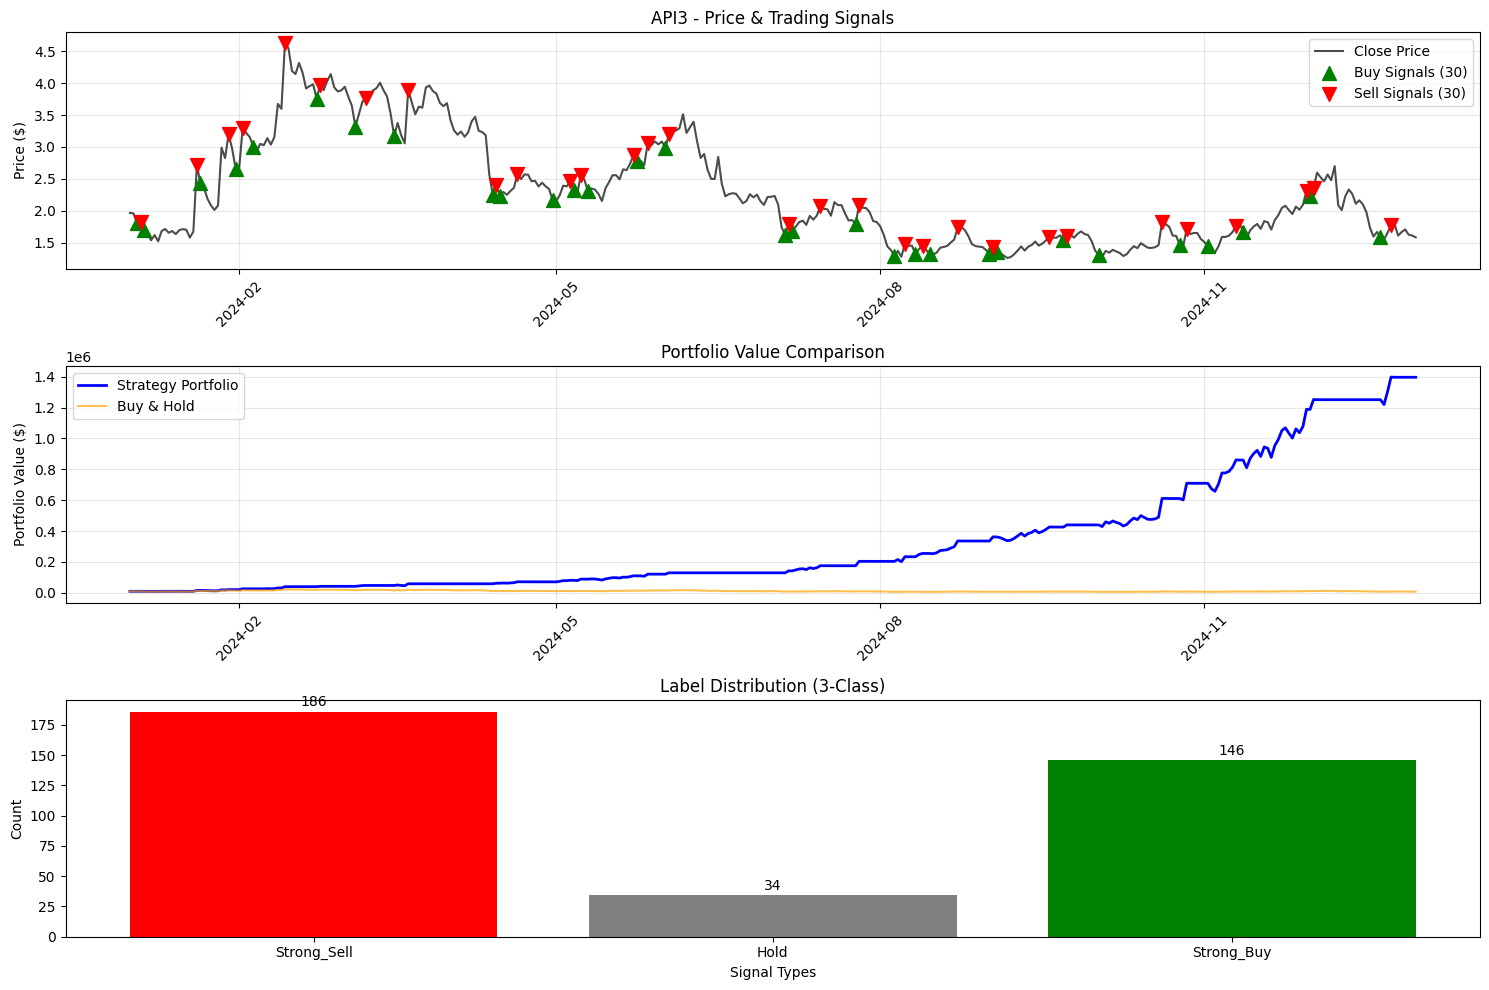


APT21794 백테스팅 결과:
전략 수익률: 6263.30%
Buy & Hold 수익률: -12.38%
초과 수익률: 6275.69%
샤프 비율: 5.03
최대 손실폭: -11.54%
총 거래 횟수: 78회
승률: 97.44%
평균 거래수익률: 11.98%
최종 자산: $636,330


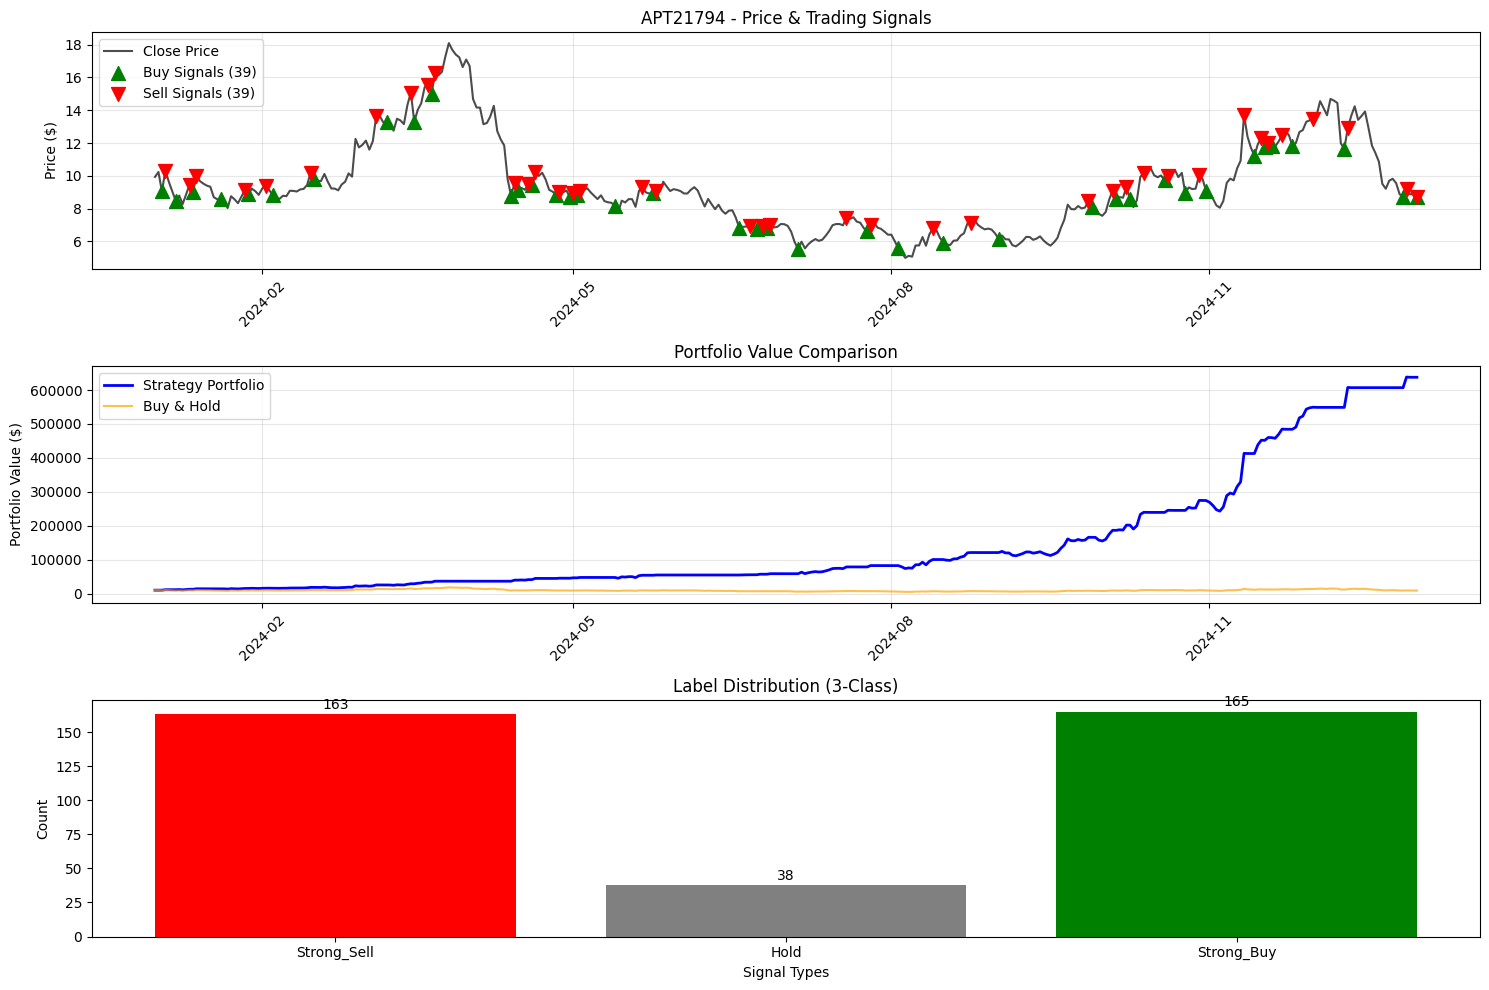


ARB11841 백테스팅 결과:
전략 수익률: 1986.85%
Buy & Hold 수익률: -58.43%
초과 수익률: 2045.28%
샤프 비율: 4.29
최대 손실폭: -15.18%
총 거래 횟수: 54회
승률: 96.30%
평균 거래수익률: 13.08%
최종 자산: $208,685


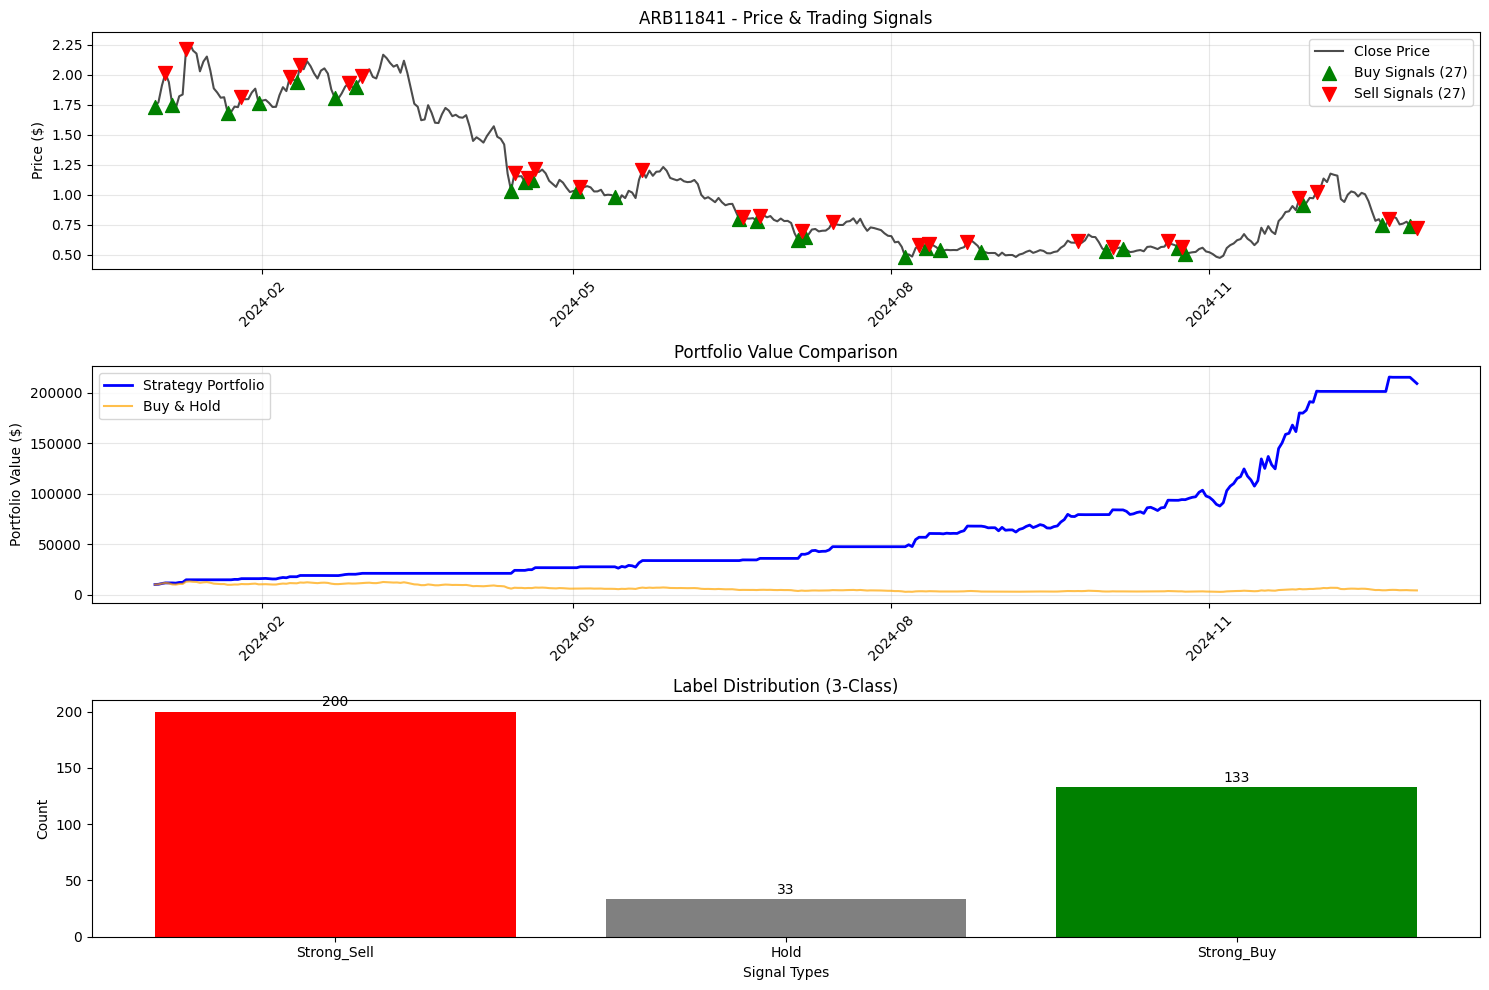


ASTR 백테스팅 결과:
전략 수익률: 1822.10%
Buy & Hold 수익률: -57.77%
초과 수익률: 1879.87%
샤프 비율: 4.77
최대 손실폭: -10.56%
총 거래 횟수: 52회
승률: 100.00%
평균 거래수익률: 12.84%
최종 자산: $192,210


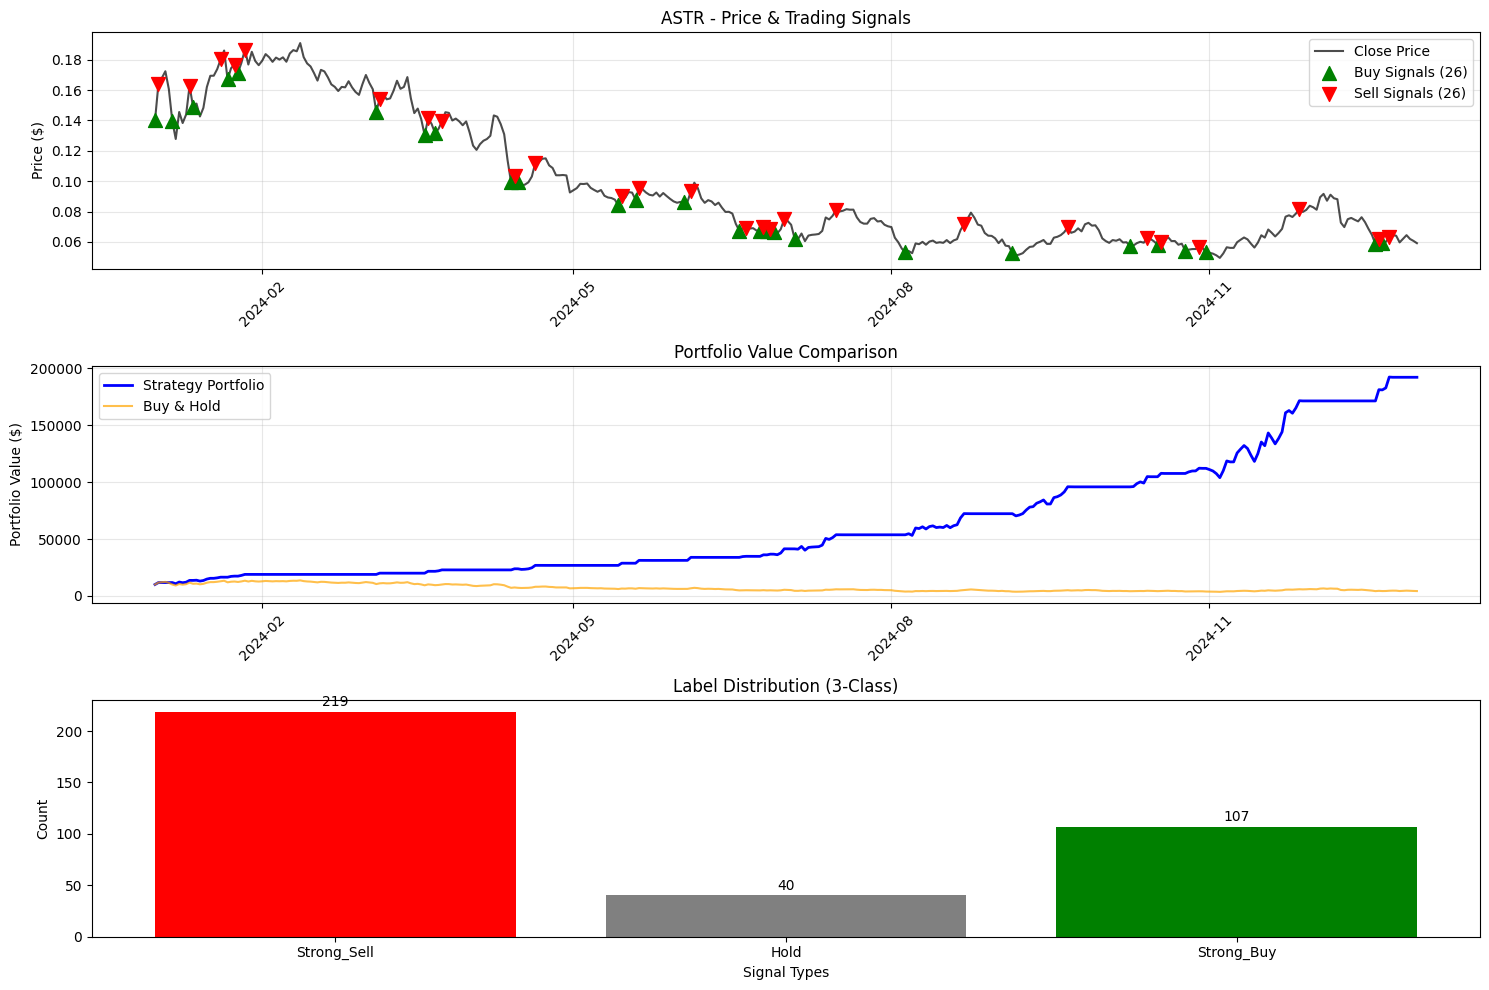


ATOM 백테스팅 결과:
전략 수익률: 1662.25%
Buy & Hold 수익률: -44.76%
초과 수익률: 1707.01%
샤프 비율: 4.56
최대 손실폭: -13.68%
총 거래 횟수: 54회
승률: 96.30%
평균 거래수익률: 12.47%
최종 자산: $176,225


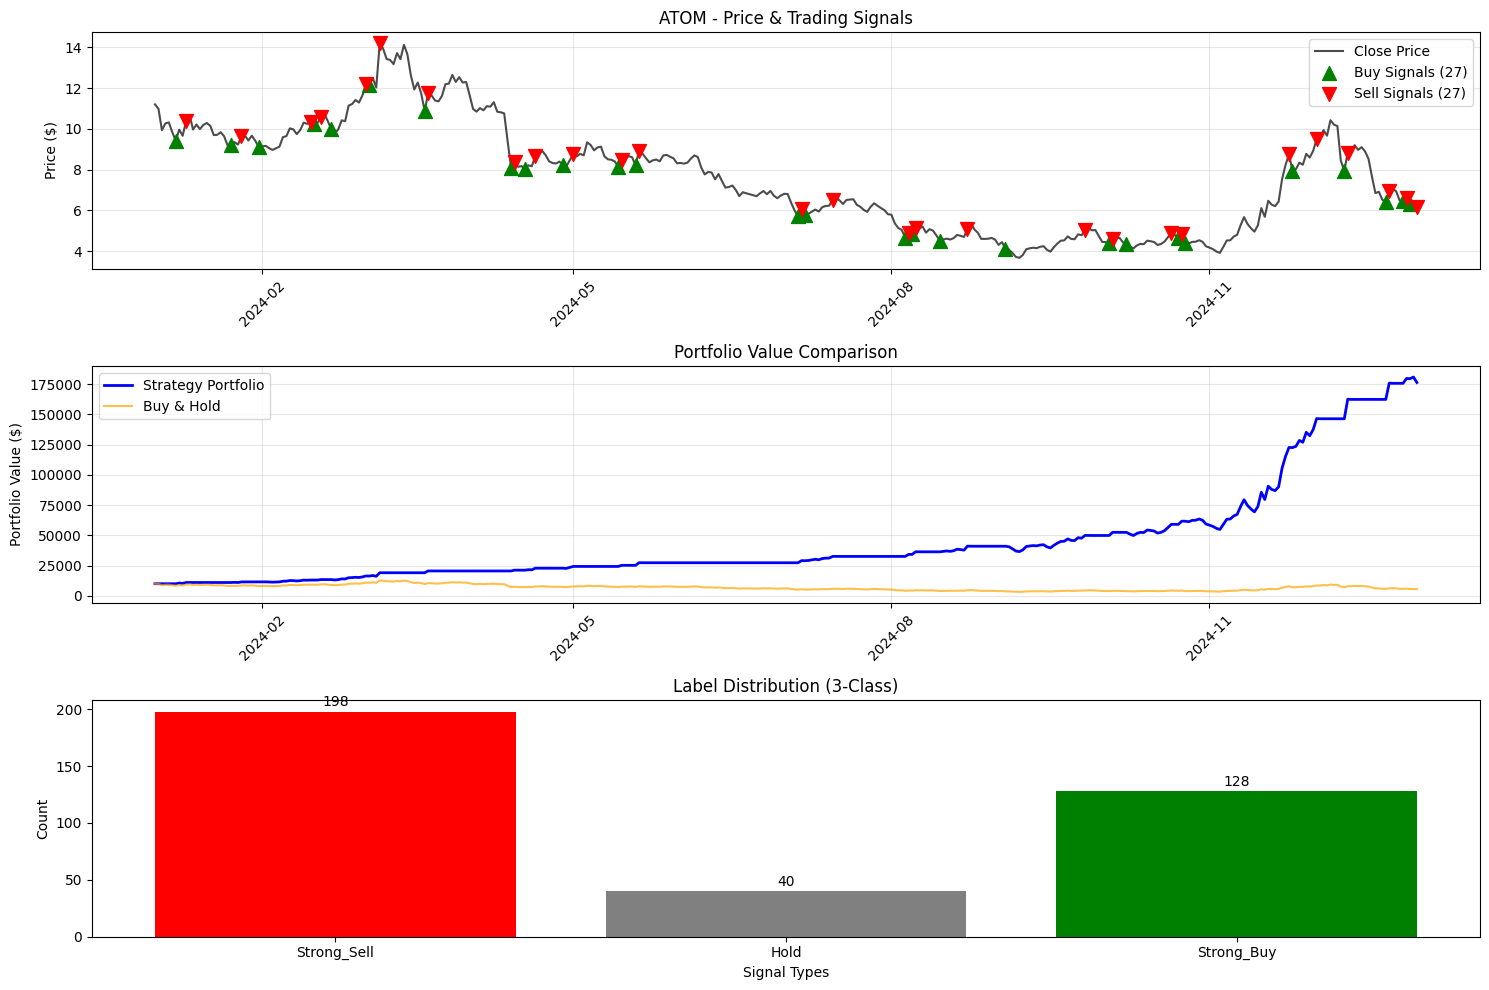


전체 백테스팅 결과 요약:
  Symbol  Total_Return  Buy_Hold_Return  Excess_Return  Sharpe_Ratio  Max_Drawdown  Win_Rate  Num_Trades
   1INCH        44.072           -0.217         44.289         4.988        -0.138     0.967          60
    AAVE        57.684            1.660         56.025         4.526        -0.180     0.962          52
     ADA        27.064            0.354         26.710         4.822        -0.144     0.958          48
    ALGO        39.688            0.396         39.291         4.212        -0.162     1.000          46
    ANKR        49.288            0.130         49.158         5.517        -0.143     0.960          50
    API3       138.610           -0.194        138.804         4.077        -0.174     1.000          60
APT21794        62.633           -0.124         62.757         5.027        -0.115     0.974          78
ARB11841        19.868           -0.584         20.453         4.295        -0.152     0.963          54
    ASTR        18.221           -0.578

In [7]:
# 연도별 백테스팅 실행
if __name__ == "__main__":
    
    # 백테스팅할 연도 범위 설정
    start_year = 2022
    end_year = 2024
    
    # 각 연도별 결과 저장
    yearly_results = {}
    
    print("연도별 백테스팅 시작")
    print("=" * 50)
    
    for year in range(start_year, end_year + 1):
        print(f"\n{year}년 백테스팅 실행 중...")
        
        try:
            # 해당 연도 기간 설정
            start_date = f'{year}-01-01'
            end_date = f'{year}-12-31'
            
            # 백테스팅 실행
            backtester = run_individual_backtest(
                data_path=save_path_1,
                start_date=start_date,
                end_date=end_date,
                max_stocks=10,               # 처음 n개 종목만 테스트
                initial_capital=10000
            )
            
            # 해당 연도 결과 저장
            yearly_results[year] = {
                'backtester': backtester,
                'period': f'{start_date} ~ {end_date}'
            }
            
            print(f"{year}년 백테스팅 완료")
            
        except Exception as e:
            print(f"{year}년 백테스팅 실패: {e}")
            yearly_results[year] = None
    
    print("\n" + "=" * 50)
    print("전체 연도별 백테스팅 완료")
    
    # 연도별 결과 요약
    print("\n연도별 결과 요약:")
    for year, result in yearly_results.items():
        if result is not None:
            print(f"{year}년: 성공")
        else:
            print(f"{year}년: 실패")